In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from data_parsing import DataParser
from functools import partial, reduce
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

In [5]:
#trajectories, status = load_trajectories('data/MITxPRO+AMxB+1T2018/edges', 'data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
dataAM = DataParser('data/MITxPRO+AMxB+1T2018/edges', 'data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
#trajectories = load_trajectories('data/MITxPRO+LASERxB1+1T2019/LaaL')
#id_and_performance = pd.read_csv('data/MITxPRO-AMxB-1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
#id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
#id_and_performance.iloc[0]
#id_and_performance

In [6]:
status = dataAM.status
trajectories = dataAM.trajectories

In [3]:
# node list of all students' learning pathway networks
AM_nodelist = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-cohort.csv')
url_id_to_url_hexname = dict(zip(AM_nodelist['order'], AM_nodelist['id']))
#LaaL_nodelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes.csv')
#url_id_to_url_hexname = dict(zip(LaaL_nodelist['order'], LaaL_nodelist['name']))
url_id_to_url_hexname[0] = 'done with course'
def traj_to_edge_csv(traj, fname):
    edges = []
    urls = [url_id_to_url_hexname[url] for url in traj][1:-1]
    for edge in zip(urls[:-1], urls[1:]):
            # unpack those two items in the in the pair, and convert them from idex id
            edges.append(edge)
    df = pd.DataFrame(data=edges, columns = ['from', 'to'])
    df.to_csv(fname, index=False)
#traj_to_edge_csv(trajectories.iloc[0], 'test_traj')

In [4]:
#AM_modules = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-modules.txt', sep='\t', encoding='utf-16')


Maximum trajectory identified by number of clicks:  1699


Text(0, 0.5, 'Count of students')

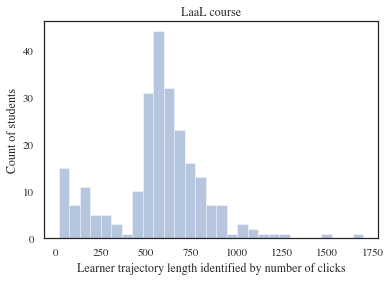

In [5]:
sb.set(context='notebook', style='white', palette='deep', font='Times', font_scale=1, color_codes=True, rc=None)
traj_lengths = trajectories.map(len).values
sb.distplot(traj_lengths, kde=False)
print("Maximum trajectory identified by number of clicks: ", max(traj_lengths))
plt.title('LaaL course')
plt.xlabel('Learner trajectory length identified by number of clicks')
plt.ylabel('Count of students')

## data generators 

In [7]:
index = np.arange(len(trajectories))
np.random.seed(9)
np.random.shuffle(index)

incoming_traj = []
outgoing_traj = []

# this split assumes that we don't need to rebalance for unequal category weights
n_valid = int(2*np.sqrt(len(trajectories)))
n_train = len(trajectories) - n_valid
success_rate = status[index[:n_train]].sum() / n_train

for traj in trajectories.values:
    incoming_traj.append(np.array(traj[:-1]).reshape(1,-1))
    outgoing_traj.append(np.array(traj[1:]).reshape(-1,1))

def data_generator(start, stop, use_status):
     while True:
        for i in range(start, stop):        
            x = incoming_traj[index[i]].reshape(1,-1)
            s = np.broadcast_to(status[index[i]], x.shape)
            y = outgoing_traj[index[i]].reshape(1,-1)
            if use_status:
                yield [x,s],y
            else:
                yield x,y

train_generator_simp = partial(data_generator, 0, n_train, False)
valid_generator_simp = partial(data_generator, n_train, n_train+n_valid, False)
train_generator_cond = partial(data_generator, 0, n_train, True)
valid_generator_cond = partial(data_generator, n_train, n_train+n_valid, True)
success_rate

0.06190476190476191

## Define models

In [7]:
hidden_dim = 37
embedding_dim = 30
# turning trajectories into sets of URLs
optimizer = Adam(learning_rate=0.001)
number_of_URL = max(trajectories.sum()) + 1
#number_of_URL = 1121

In [8]:
input_ = Input(shape=(None,), name='history')
embed = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_)

rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed)

predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(rnn)

model_simp = Model(inputs=input_, outputs=predicted_URL, name='Simple_model')
model_simp.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model_simp.summary()

Model: "Simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
history (InputLayer)         [(None, None)]            0         
_________________________________________________________________
URL_embedding (Embedding)    (None, None, 30)          22620     
_________________________________________________________________
LSTM (LSTM)                  (None, None, 37)          10064     
_________________________________________________________________
Predicted_URL (Dense)        (None, None, 754)         28652     
Total params: 61,336
Trainable params: 61,336
Non-trainable params: 0
_________________________________________________________________


In [10]:
# input_x = Input(shape=(None,), name='history')
# input_s = Input(shape=(None,), name='status')
# embed_x = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_x)
# embed_s = Embedding(2, hidden_dim, embeddings_initializer='ones', name='Status_embedding')(input_s)

# rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed_x)
# masked = Multiply()([rnn, embed_s])

# predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(masked)

# model_cond = Model(inputs=[input_x, input_s], outputs=predicted_URL, name='Conditional_model')
# model_cond.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
# model_cond.summary()

Model: "Conditional_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
history (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
URL_embedding (Embedding)       (None, None, 30)     13980       history[0][0]                    
__________________________________________________________________________________________________
status (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
LSTM (LSTM)                     (None, None, 60)     21840       URL_embedding[0][0]              
__________________________________________________________________________________

## Run models

In [11]:
#model_simp.load_weights('weights/AM_cond_hiddim37_02-.hdf5')
#model_cond.load_weights('weights/LaaL_cond_hiddim60-.hdf5', by_name=True)

In [ ]:
#filepath="AM_cond_hiddim37_02-.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model_cond.fit_generator(train_generator_cond(), 
                    validation_data=valid_generator_cond(),
                    callbacks=callbacks_list,
                    steps_per_epoch = n_train, #batch size is inherently 1 via generator
                    validation_steps= n_valid,
                    epochs=150,
                    verbose=1,)

## Sample trajectory creation 

In [ ]:
proposed_traj = [0]
visit_count = defaultdict(int)
max_allowed_visits = 25

while len(proposed_traj) < 1000 and (len(proposed_traj) == 1 or proposed_traj[-1] != 0):
    x = np.array(proposed_traj).reshape(1,-1)
    #run with s = np.ones(x.shpae) for successful
    s = np.zeros(x.shape)
    for url in reversed(np.argsort(model_cond.predict([x,s])[0,-1])):
    #for url in reversed(np.argsort(model_simp.predict(x)[0,-1])):
        if visit_count[url] < max_allowed_visits:
            proposed_traj.append(url)
            visit_count[url] += 1
            break
    #predicted = np.argmax(model.predict(x)[0,-1])
    print(url)
    
# print(proposed_traj)

# cert_traj = pd.DataFrame(proposed_traj)
# cert_traj.to_csv('LaaL_simp_traj_hid_dim37.csv', header = ['simple trajectory'], index = False)
traj_to_edge_csv(proposed_traj, 'MITxPRO+LASERxB1+1T2019_simulated_unsuccessfulEXTRA_Hdim37.csv')

In [ ]:
# # this is to pull out the "recommended traj" 
# proposed_traj = [0]
# visit_count = defaultdict(int)
# max_allowed_visits = 25

# while len(proposed_traj) < 1000 and (len(proposed_traj) == 1 or proposed_traj[-1] != 0):
#     x = np.array(proposed_traj).reshape(1,-1)
#     #run with s = np.ones(x.shpae) for successful
#     s = np.ones(x.shape)
#     u = np.zeros(x.shape)
#     pred_s = model_cond.predict([x,s])[0,-1]
#     pred_u = model_cond.predict([x,u])[0,-1]
#     for url in reversed(np.argsort(pred_s - pred_u)):
#         if visit_count[url] < max_allowed_visits:
#             proposed_traj.append(url)
#             visit_count[url] += 1
#             break
#     #predicted = np.argmax(model.predict(x)[0,-1])
#     print(url)
    
# # print(proposed_traj)

# # cert_traj = pd.DataFrame(proposed_traj)
# # cert_traj.to_csv('LaaL_simp_traj_hid_dim37.csv', header = ['simple trajectory'], index = False)
# traj_to_edge_csv(proposed_traj, 'MITxPRO+AMxB+1T2018_simulated_RECOMMENDEDsuccessful_Hdim60.csv')

## Probability estimation

In [12]:
def score_traj(sample_traj):
    x = np.array(sample_traj[:-1]).reshape(1,-1)
    successful = np.ones(x.shape)
    unsuccessful = np.zeros(x.shape)
    cond_prob_successful = np.array(model_cond([x, successful])).reshape(-1, number_of_URL)
    cond_prob_unsuccessful = np.array(model_cond([x, unsuccessful])).reshape(-1, number_of_URL)

    score_s = []
    score_u = []

    for choice, prob_s, prob_u in zip(sample_traj[1:], cond_prob_successful, cond_prob_unsuccessful):
        score_s.append(np.log(prob_s[choice]))
        score_u.append(np.log(prob_u[choice]))
    return score_s, score_u

In [13]:
def predict_success(traj):
    score_s, score_u = score_traj(traj)
    evidence_s = np.log(success_rate) + np.sum(score_s)
    evidence_u = np.log(1 - success_rate) + np.sum(score_u)
    prob_of_success = 1 / (1 + np.exp(evidence_u - evidence_s))
    return prob_of_success

In [14]:
y_true = []
y_pred = []

for i in range(n_train, n_train+n_valid):
    user = index[i]
    traj = trajectories.iloc[user]
    y_true.append(status[user])
    y_pred.append(predict_success(traj))

In [ ]:
print(list(zip(y_true,y_pred)))
df = pd.DataFrame(confusion_matrix(y_true, np.round(y_pred)))
df.columns = ['Predicted unsuccessful', 'Predicted successful']
df.index = ['Actual unsuccessful', 'Actual successful']
df
# columns are predictions, rows are true

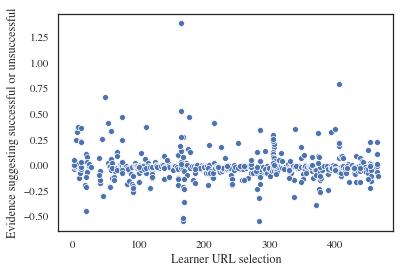

168
168 -1.7244986 -1.1799337
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 2, 5, 12, 20, 22, 24, 21, 20, 18, 24, 22, 20, 28, 20, 1, 49, 53, 54, 55, 56, 58, 59, 41, 44, 45, 58, 41, 59, 58, 59, 57, 63, 64, 61, 63, 64, 60, 41, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 75, 74, 75, 82, 85, 86, 90, 84, 88, 90, 91, 67, 94, 95, 96, 97, 98, 99, 91, 103, 101, 91, 102, 101, 103, 104, 105, 106, 107, 109, 100, 109, 111, 108, 114, 112, 120, 117, 114, 116, 120, 112, 118, 120, 121, 91, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 144, 145, 147, 139, 143, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 139, 160, 164, 160, 165, 167]


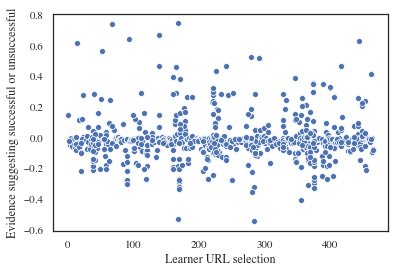

284
284 -1.6885277 -1.1454195
[0, 39, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 17, 15, 17, 18, 12, 18, 20, 24, 22, 20, 28, 29, 31, 32, 31, 29, 34, 35, 36, 37, 38, 39, 40, 24, 21, 22, 20, 39, 40, 39, 40, 39, 41, 44, 45, 41, 47, 46, 51, 50, 58, 59, 58, 41, 59, 64, 63, 57, 61, 63, 64, 60, 41, 67, 39, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 67, 85, 86, 84, 90, 88, 90, 91, 39, 46, 47, 49, 51, 53, 54, 55, 56, 59, 39, 94, 95, 96, 97, 98, 99, 91, 101, 103, 104, 105, 106, 107, 109, 100, 109, 111, 108, 114, 160, 164, 163, 160, 164, 112, 91, 114, 116, 120, 112, 120, 118, 91, 121, 125, 126, 127, 129, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 139, 160, 164, 139, 158, 139, 160, 164, 165, 160, 167, 165, 168, 160, 164, 160, 165, 167, 168, 165, 139, 147, 146, 139, 121, 136, 129, 134, 128, 121, 91, 120, 117, 112, 109, 101, 108, 103, 100, 168, 169, 172, 171, 172, 169, 172, 169, 172, 173, 169, 175

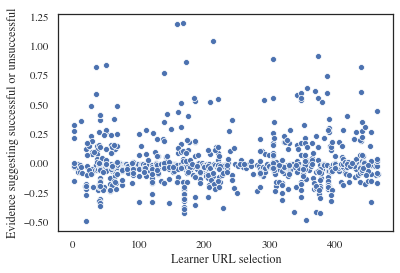

20
20 -2.703085 -2.2097797
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 12, 20, 21]


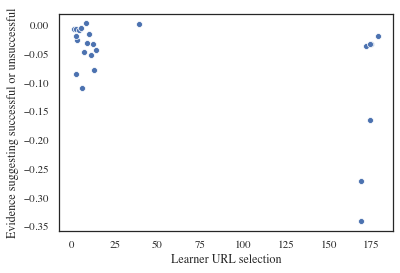

169
169 -3.69991 -3.3593283
[0, 39, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14]


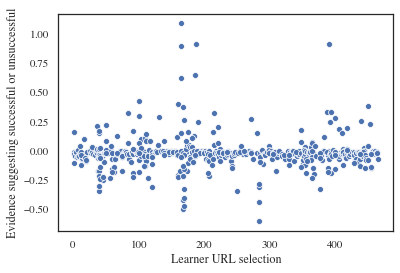

284
284 -2.6522818 -2.0491667
[0, 169, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 12, 11, 12, 13, 14, 17, 15, 17, 18, 12, 18, 20, 24, 22, 26, 20, 28, 29, 31, 29, 34, 35, 36, 37, 36, 38, 37, 38, 39, 40, 169, 172, 39, 40, 39, 40, 41, 39, 44, 45, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 59, 58, 59, 57, 63, 64, 61, 63, 64, 60, 41, 67, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 84, 82, 85, 86, 84, 90, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 103, 101, 103, 104, 105, 106, 107, 101, 100, 109, 91, 109, 111, 108, 114, 109, 114, 116, 112, 120, 39, 100, 91, 101, 103, 100, 109, 114, 108, 120, 112, 118, 120, 91, 121, 125, 126, 127, 129, 121, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 158, 152, 158, 159, 139, 160, 164, 160, 163, 39, 46, 41, 47, 46, 51, 164, 41, 51, 58, 50, 59, 164, 165, 160, 167, 168, 165, 169, 168, 172, 173, 175, 169, 175, 177, 174, 179, 181, 179, 186, 169, 184, 181, 182, 181, 178, 183, 182, 185, 169, 188, 190,

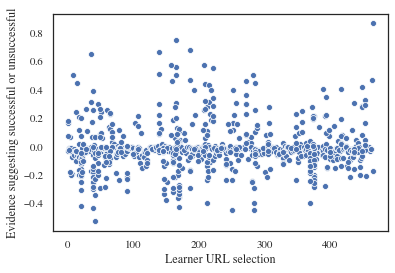

41
41 -1.9304434 -1.4047307
[0, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 8, 9, 10, 11, 2, 12, 13, 14, 17, 15, 12, 17, 15, 17, 18, 12, 18, 20, 24, 22, 20, 21, 28, 20, 29, 28, 29, 31, 29, 34, 35, 36, 35, 1, 20, 1, 18, 20, 18, 24, 22, 20, 22, 26, 20, 36, 37, 36, 38, 37, 38, 39, 40, 39, 160, 39, 160, 169, 172, 39, 40, 39, 41, 44, 45, 41, 47, 49, 51, 46, 51, 53, 54, 55, 56, 58, 50, 59, 58, 59, 64, 63, 57, 61, 63, 64, 60, 65, 41, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91, 39, 91, 94, 95, 96, 97, 98, 99, 91, 103, 101, 103, 104, 105, 106, 107, 100, 109, 108, 91, 108, 109, 111, 108, 114, 91, 114, 116, 112, 120, 117, 120, 91, 118, 120, 91, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 39, 74, 67, 75, 81, 80, 79, 78, 77, 74, 82, 39, 41, 46, 47, 49, 51, 46, 53, 54, 55, 56, 59, 50, 58, 57, 63, 64, 63, 60, 67, 41, 39, 46]


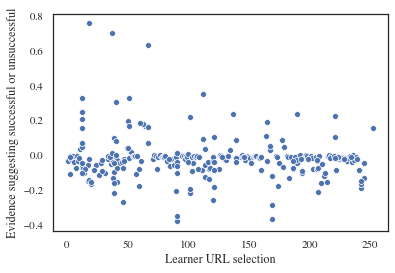

91
91 -2.4631956 -2.0834455
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 2, 18, 12, 11, 2, 12, 39, 40, 41, 39, 44, 45, 41, 47, 49, 51, 46, 51, 53, 54, 55, 56, 50, 59, 58, 59, 64, 63, 57, 61, 60, 40, 39, 41, 50, 51, 46, 47, 12, 13, 14, 17, 15, 17, 18, 12, 18, 20, 24, 22, 26, 20, 28, 29, 31, 34, 29, 34, 35, 36, 37, 38, 37, 39, 38, 40, 39, 40, 12, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 90, 84, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 101, 91, 103, 12, 100]


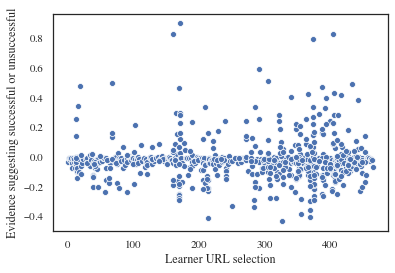

327
327 -3.824442 -3.3921342
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 12, 17, 16, 15, 17, 18, 12, 18, 19, 18, 12, 13, 14, 15, 17, 12, 18, 20, 24, 22, 20, 24, 20, 28, 29, 31, 34, 29, 34, 35, 36, 37, 38, 39, 38, 40, 39, 41, 44, 45, 47, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 59, 58, 59, 57, 63, 64, 61, 63, 64, 60, 67, 41, 71, 72, 73, 75, 67, 75, 39, 40, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 103, 101, 91, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 116, 112, 120, 118, 120, 91, 121, 125, 126, 127, 129, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 139, 160, 164, 160, 165, 167, 165, 168, 169, 172, 168, 160, 164, 169, 172, 173, 169, 175, 177, 174, 179, 181, 178, 183, 182, 185, 169, 186, 188, 190, 186, 190, 192, 189, 194, 186, 190, 189, 194, 196, 197, 198, 193, 200, 201, 202, 203, 199, 205, 206, 186, 207, 208, 207, 208, 206, 21

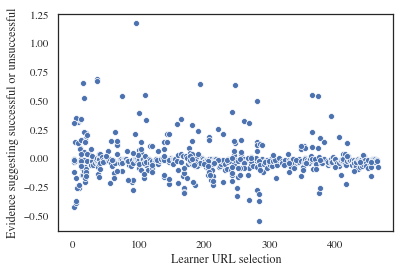

284
284 -1.7400132 -1.1963575
[0, 1, 2, 3, 7, 8, 11, 10, 11, 9, 10, 12, 2, 18, 12, 18, 1, 3, 5, 4, 5, 6, 4, 8, 9, 11, 2, 12, 13, 12, 20, 13, 12, 13, 14, 15, 17, 12, 18, 20, 18, 24, 22, 1, 12, 16, 17, 18, 20, 24, 16, 12, 22, 17, 15, 12, 22, 20, 28, 20, 29, 28, 29, 31, 29, 34, 35, 36, 37, 38, 37, 39, 38, 40, 37, 38, 39, 40, 18, 39, 40, 41, 44, 45, 41, 47, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 57, 63, 64, 61, 64, 63, 60, 67, 41, 67, 71, 72, 73, 67, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 90, 84, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 101, 75, 67, 82, 84, 101, 91, 103, 109, 100, 108, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 112, 109, 114, 108, 116, 120, 112, 118, 117, 96, 94, 99, 103, 100, 120, 118, 120, 91, 121, 125, 126, 127, 129, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 139, 143, 144, 145, 139, 147, 143, 146, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 139, 160, 159, 139, 143, 160, 164, 160, 165, 167, 165, 168

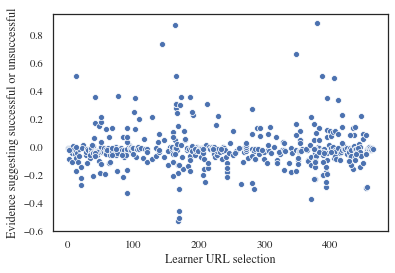

168
168 -1.7861097 -1.2554321
[0, 39, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 15, 17, 12, 18, 20, 24, 22, 12, 20, 28, 20, 29, 28, 29, 31, 34, 29, 35, 34, 35, 36, 37, 38, 39, 40, 41, 39, 44, 45, 41, 47, 46, 51, 50, 47, 49, 51, 47, 50, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 63, 57, 64, 61, 63, 64, 60, 67, 41, 71, 72, 73, 75, 67, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 91, 67, 94, 95, 96, 97, 98, 99, 101, 103, 91, 103, 104, 105, 106, 107, 100, 109, 108, 114, 116, 120, 112, 118, 120, 91, 121, 129, 128, 135, 134, 137, 139, 143, 139, 147, 146, 153, 154, 155, 156, 152, 158, 159, 139, 160, 164, 165, 160, 167, 165, 168, 164, 12, 168, 160, 164, 160, 165, 167]


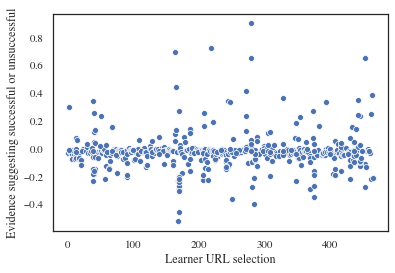

168
168 -1.8718683 -1.3520943
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 13, 14, 12, 15, 17, 18, 12, 18, 20, 24, 22, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38, 39, 40, 39, 40, 39, 40, 41, 39, 41, 44, 45, 41, 47, 49, 51, 46, 51, 53, 54, 55, 56, 59, 58, 50, 58, 59, 57, 63, 64, 61, 63, 64, 60, 41, 67, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 90, 84, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 101, 103, 104, 105, 106, 107, 109, 100, 109, 111, 108, 114, 116, 120, 112, 118, 120, 121, 91, 125, 126, 127, 129, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 144, 145, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 160, 139, 164, 160, 164, 165, 160, 167]


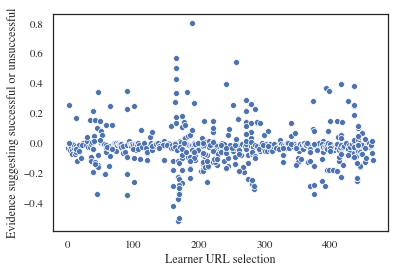

168
168 -1.892922 -1.3695976
[0, 1, 2, 3, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 13, 14, 15, 17, 18, 12, 18, 20, 24, 22, 20, 28, 29, 31, 29, 34, 35, 34, 36, 35, 36, 37, 38, 39, 40, 41, 39, 45, 44, 41, 47, 39, 40, 12, 47, 49, 46, 51, 47, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 57, 64, 63, 61, 63, 64, 60, 41, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 90, 84, 88, 90, 91, 67, 94, 95, 96, 97, 98, 99, 101, 91, 103, 101, 103, 91, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 116, 112, 120, 91, 121, 125, 126, 127, 129, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 158, 152, 158, 159, 139, 160, 164, 165, 160, 167]


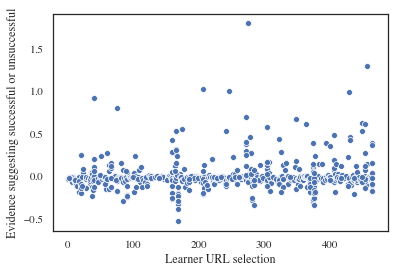

168
168 -1.6842569 -1.157137
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 15, 17, 18, 12, 18, 20, 18, 24, 22, 20, 28, 20, 29, 28, 29, 31, 34, 29, 35, 34, 36, 35, 37, 36, 38, 37, 39, 38, 40, 39, 40, 20, 21, 24, 22, 40, 39, 40, 41, 39, 44, 45, 41, 47, 49, 51, 46, 51, 53, 54, 55, 56, 50, 59, 58, 59, 63, 64, 57, 61, 63, 60, 67, 41, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 103, 101, 91, 101, 75, 82, 91, 67, 90, 84, 67, 91, 101, 103, 104, 105, 106, 107, 109, 100, 109, 111, 108, 114, 91, 114, 116, 112, 120, 118, 120, 121, 91, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 139, 160, 164, 165, 160, 167, 165, 168, 160, 164, 160, 165, 167]


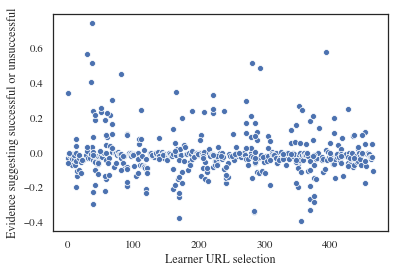

355
355 -1.6388688 -1.244843
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 1, 36, 37, 38, 37, 1, 12, 13, 14, 17, 15, 17, 18, 12, 18, 20, 24, 22, 20, 28, 29, 31, 29, 34, 35, 37, 38, 29, 38, 39, 38, 40, 41, 39, 44, 45, 41, 47, 49, 51, 46, 51, 53, 54, 55, 56, 50, 59, 58, 57, 58, 41, 58, 59, 57, 64, 63, 61, 60, 59, 64, 57, 63, 60, 67, 39, 41, 67, 41, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 90, 84, 90, 88, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 104, 105, 106, 107, 109, 100, 109, 111, 108, 114, 109, 112, 114, 108, 116, 112, 120, 91, 117, 120, 82, 67, 82, 91, 117, 120, 118, 91, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 160, 139, 41, 46, 47, 51, 46, 160, 164, 160, 165, 167, 165, 168, 169, 172, 160, 163, 164, 169, 172, 173, 175, 169, 175, 177, 174, 179, 181, 178, 183, 182, 185, 169, 186, 188, 190, 186, 190, 192, 189, 194, 196, 197, 198, 193, 200, 201, 203, 

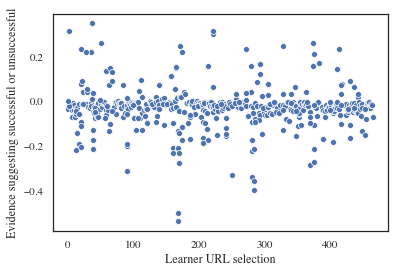

168
168 -1.6957493 -1.1589515
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 2, 12, 13, 14, 15, 17, 18, 12, 18, 20, 18, 24, 22, 20, 28, 29, 31, 29, 34, 35, 36, 37, 36, 37, 38, 39, 38, 40, 20, 21, 28, 20, 1, 21, 22, 24, 39, 40, 39, 41, 44, 45, 47, 41, 47, 49, 51, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 63, 64, 57, 61, 63, 64, 60, 67, 41, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 91, 67, 92, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 104, 105, 106, 107, 109, 100, 109, 111, 114, 108, 114, 91, 114, 116, 112, 120, 118, 120, 91, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 134, 136, 135, 134, 137, 139, 121, 143, 144, 145, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 158, 152, 158, 159, 139, 160, 164, 160, 165, 167]


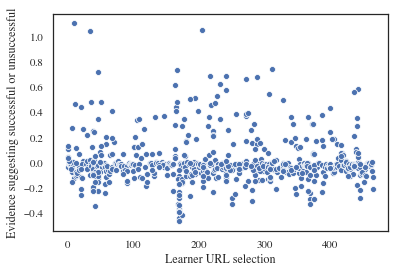

169
169 -2.9807603 -2.5190766
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 9, 8, 7, 6, 5, 2, 12, 39, 40, 12, 13, 14, 17, 15, 17, 12, 18, 20, 24, 22, 20, 28, 29, 31, 34, 29, 34, 35, 36, 1, 29, 1, 20, 21, 1, 36, 37, 38, 39, 40, 21, 24, 22, 1, 39, 40, 41, 39, 44, 45, 47, 39, 41, 46, 41, 47, 49, 46, 51, 53, 54, 55, 56, 58, 50, 59, 58, 51, 57, 51, 47, 50, 41, 57, 58, 59, 41, 40, 47, 51, 46, 50, 47, 59, 57, 64, 63, 61, 63, 64, 60, 41, 67, 39, 67, 39, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 67, 91, 94, 95, 96, 97, 98, 99, 103, 91, 101, 103, 101, 106, 105, 101, 104, 107, 100, 109, 111, 109, 114, 108, 116, 114, 120, 112, 120, 118, 91, 121, 125, 126, 127, 121, 129, 133, 132, 129, 131, 128, 135, 134, 137, 139, 121, 143, 144, 145, 139, 147, 149, 150, 147, 151, 146, 153, 154, 155, 156, 152, 158, 159, 160, 139, 164, 160, 164, 165, 167, 39, 168, 167, 165, 169, 168, 172, 47, 164, 169, 172, 173, 169, 175, 169, 177, 181, 174, 169, 181, 178, 169, 272, 169, 174]


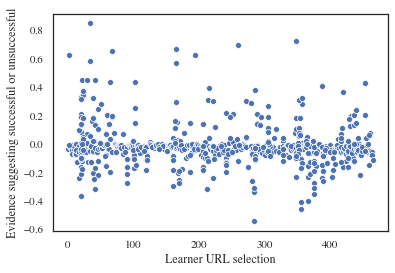

284
284 -1.5093497 -0.96811926
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 13, 14, 15, 17, 18, 12, 18, 20, 24, 22, 20, 28, 20, 29, 28, 29, 31, 29, 34, 35, 36, 37, 38, 20, 21, 22, 21, 24, 20, 18, 20, 21, 24, 38, 21, 24, 22, 18, 22, 20, 28, 29, 31, 29, 34, 35, 34, 36, 35, 37, 36, 37, 38, 39, 40, 41, 39, 44, 45, 47, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 59, 58, 59, 58, 64, 63, 57, 61, 60, 63, 65, 41, 65, 60, 41, 67, 39, 20, 21, 22, 24, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 39, 40, 21, 24, 22, 34, 100, 103, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 116, 120, 112, 118, 120, 121, 91, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 160, 139, 164, 160, 165, 167, 20, 21, 24, 22, 165, 167, 160, 165, 164, 165, 160, 167, 165, 168, 169, 172, 160, 164, 34, 160, 164, 29, 169, 172, 173, 169, 175, 177, 

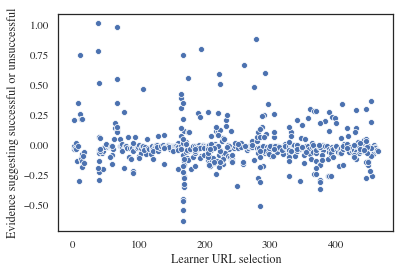

168
168 -2.23934 -1.6057076
[0, 1, 2, 3, 11, 4, 5, 6, 9, 10, 8, 7, 2, 12, 169, 172, 168, 169, 165, 168, 167]


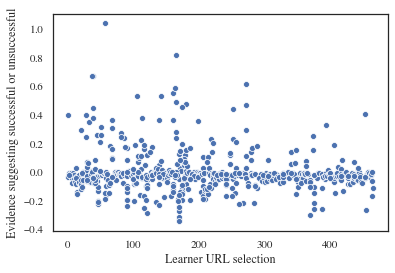

169
169 -1.9950947 -1.6541535
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 1, 13, 14, 15, 17, 18, 12, 18, 20, 24, 22, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38, 20, 21, 22, 24, 22, 21, 38, 28, 29, 32, 31, 29, 31, 29, 34, 35, 36, 37, 38, 37, 28, 29, 39, 40, 41, 39, 44, 45, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 59, 58, 41, 58, 59, 51, 57, 47, 50, 46, 45, 47, 51, 46, 59, 57, 64, 63, 61, 63, 64, 60, 67, 41, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 57, 41, 67, 86, 84, 90, 67, 90, 82, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 101, 103, 105, 104, 106, 107, 100, 109, 39, 91, 108, 109, 111, 108, 114, 112, 120, 117, 120, 121, 91, 129, 121, 128, 134, 139, 121, 143, 139, 147, 146, 158, 152, 139, 160, 164, 165, 160, 167, 165, 168, 169, 172, 173, 175, 169, 175, 169, 175, 177, 174, 181, 179, 181, 178, 169, 172, 169, 175, 174, 179, 181, 169, 178, 181, 179, 178, 181, 182, 179, 178, 183, 182, 185, 186, 169, 188, 186, 190, 192, 189, 194, 196, 197, 198, 193, 200, 201, 202, 1

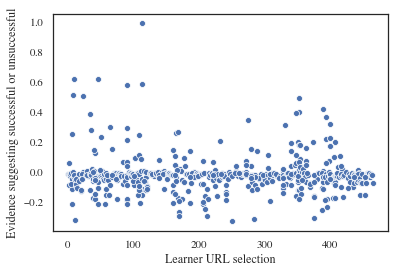

250
250 -0.928667 -0.60499144
[0, 39, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 9, 11, 8, 7, 6, 5, 2, 12, 13, 14, 15, 17, 18, 12, 18, 20, 24, 22, 24, 22, 20, 28, 29, 31, 34, 29, 34, 35, 36, 37, 36, 38, 37, 38, 39, 40, 41, 39, 44, 45, 41, 47, 49, 51, 46, 51, 41, 39, 40, 39, 41, 47, 41, 46, 51, 53, 54, 55, 56, 50, 59, 58, 46, 47, 58, 59, 57, 64, 63, 61, 63, 64, 60, 41, 67, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 103, 101, 103, 104, 105, 106, 107, 100, 109, 91, 101, 103, 91, 109, 111, 108, 114, 91, 114, 109, 112, 108, 109, 114, 116, 112, 120, 118, 120, 114, 117, 120, 91, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 144, 145, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 160, 139, 164, 160, 165, 167, 165, 168, 169, 172, 173, 169, 175, 177, 174, 179, 181, 178, 183, 182, 185, 186, 169, 188, 186, 190, 192, 189, 194, 196, 197, 198, 193, 200, 201, 202, 203, 199, 205, 18

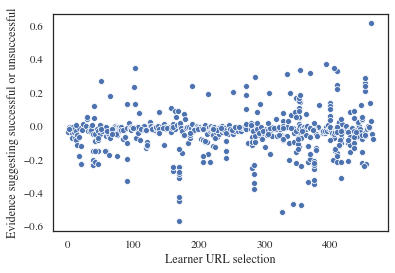

169
169 -3.0937989 -2.5264287
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 15, 17, 12, 18, 20, 18, 24, 22, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38, 39, 40, 39, 40, 39, 41, 44, 45, 41, 47, 41, 47, 49, 51, 46, 51, 53, 54, 55, 56, 50, 59, 58, 59, 64, 57, 63, 61, 63, 64, 60, 41, 67, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 90, 84, 88, 90, 91, 67, 94, 95, 96, 97, 98, 99, 101, 103, 91, 103, 104, 105, 106, 107, 109, 100, 109, 111, 108, 114, 116, 120, 112, 118, 120, 121, 91, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 144, 145, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 158, 152, 158, 159, 160, 139, 160, 164, 160, 164, 39, 46, 41, 47, 46, 51, 160, 165, 167, 169, 172, 169, 172, 168, 169, 172, 169, 172, 173, 169, 175, 177, 174, 179, 181, 178, 183, 182, 185, 169, 186, 188, 190, 186, 190, 192, 189, 194, 196, 197, 198, 193, 200, 201, 202, 203, 199, 205, 186, 206, 207, 208, 207, 208, 210, 206, 210, 212, 214, 209, 215, 214, 215, 21

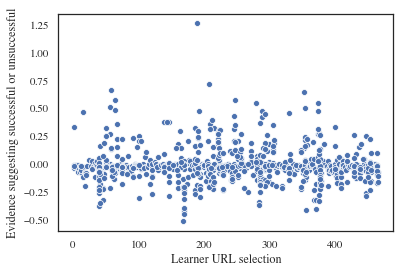

168
168 -1.5874815 -1.0746354
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 15, 14, 2, 12, 15, 17, 18, 12, 18, 20, 18, 24, 22, 20, 28, 29, 31, 34, 29, 34, 35, 36, 37, 38, 39, 40, 41, 39, 44, 45, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 57, 63, 64, 61, 63, 64, 60, 58, 57, 67, 41, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 101, 91, 103, 101, 103, 104, 105, 106, 107, 109, 100, 109, 111, 108, 114, 116, 112, 120, 91, 120, 117, 98, 120, 118, 120, 121, 91, 125, 126, 127, 129, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 144, 145, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 139, 160, 39, 40, 160, 39, 46, 41, 47, 46, 51, 39, 160, 164, 160, 165, 167]


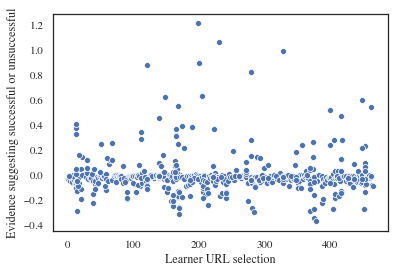

378
378 -4.2308297 -3.862078
[0, 20, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 13, 12, 13, 14, 15, 17, 12, 18, 20, 22, 24, 22, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38, 39, 40, 39, 41, 44, 45, 41, 47, 49, 51, 46, 51, 53, 54, 55, 56, 59, 50, 58, 59, 63, 64, 57, 61, 60, 41, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 104, 105, 106, 107, 100, 109, 111, 114, 108, 114, 112, 109, 112, 114, 116, 120, 112, 120, 118, 91, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 139, 147, 149, 121, 139, 121, 143, 147, 139, 149, 150, 151, 146, 147, 152, 146, 153, 154, 155, 156, 152, 158, 159, 139, 160, 164, 139, 160, 139, 158, 160, 164, 160, 165, 167, 165, 168, 169, 168, 172, 168, 160, 164, 160, 165, 167, 165, 168, 169, 175, 169, 172, 175, 177, 174, 181, 179, 181, 178, 183, 182, 185, 169, 186, 188, 186, 190, 192, 190, 189, 194, 196, 197, 198, 193, 198, 200, 201, 202, 203, 199, 205, 186, 205

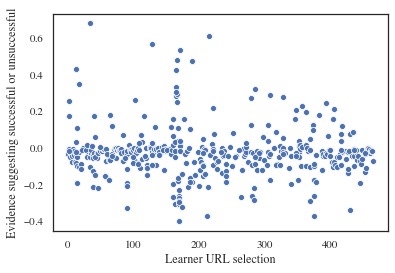

169
169 -2.7047062 -2.3068862
[0, 1, 2, 3, 2, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 12, 2, 14, 13, 14, 17, 15, 17, 12, 18, 20, 24, 22, 20, 28, 29, 31, 34, 29, 35, 34, 35, 36, 37, 38, 39, 38, 40, 39, 40, 41, 39, 44, 45, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 59, 58, 59, 64, 57, 63, 61, 63, 64, 60, 41, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 91, 67, 94, 95, 96, 97, 98, 99, 91, 101, 103, 101, 103, 104, 105, 106, 107, 100, 109, 111, 114, 108, 114, 91, 103, 109, 100, 108, 116, 112, 120, 118, 120, 121, 91, 125, 126, 127, 121, 129, 131, 132, 128, 129, 134, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 158, 152, 158, 159, 160, 139, 160, 164, 165, 167, 34, 121, 129, 168, 160, 163, 164, 160, 167, 165, 168, 169, 172, 169, 172, 169, 172, 168, 169, 168, 165, 167, 165, 160, 164, 172]


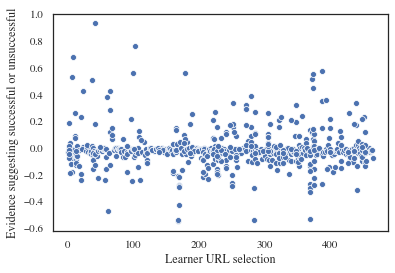

168
168 -1.7406652 -1.1932963
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 8, 7, 6, 5, 4, 3, 2, 11, 12, 2, 12, 11, 12, 2, 11, 2, 12, 11, 2, 12, 13, 14, 15, 17, 12, 18, 20, 24, 22, 24, 21, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38, 37, 38, 39, 38, 40, 41, 39, 44, 45, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 59, 58, 59, 57, 64, 63, 64, 60, 41, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91, 94, 95, 96, 97, 96, 98, 99, 91, 101, 103, 101, 103, 104, 105, 106, 107, 41, 65, 64, 61, 103, 100, 109, 101, 108, 109, 111, 108, 114, 116, 112, 120, 118, 120, 91, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 139, 160, 164, 160, 165, 167]


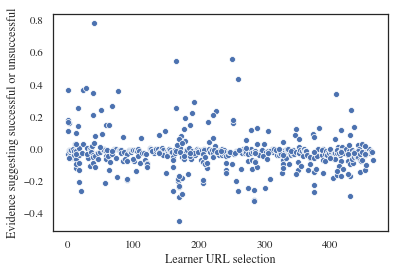

169
169 -1.3659384 -0.9158609
[0, 1, 2, 39, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 12, 11, 2, 1, 12, 13, 1, 13, 1, 16, 12, 17, 12, 16, 17, 12, 18, 1, 18, 20, 18, 24, 22, 24, 39, 40, 28, 29, 31, 34, 29, 34, 35, 36, 37, 38, 40, 39, 40, 41, 39, 44, 45, 41, 47, 49, 51, 46, 53, 54, 55, 56, 50, 58, 59, 58, 59, 57, 63, 64, 63, 64, 61, 60, 41, 67, 71, 72, 73, 75, 67, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 116, 112, 120, 118, 91, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 144, 145, 139, 147, 150, 149, 151, 146, 153, 154, 155, 156, 152, 158, 159, 139, 160, 164, 165, 160, 167, 165, 168, 169, 168, 172, 173, 169, 175, 177, 174, 179, 181, 178, 169, 160, 164, 160, 165, 167, 284]


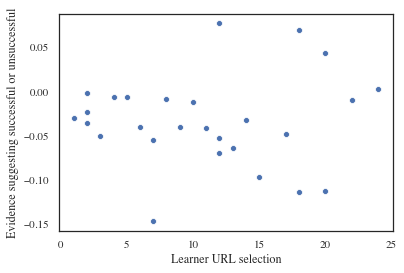

7 -0.707566 -0.5607522
[0, 20, 1, 2, 3, 4, 5, 6, 7, 2]


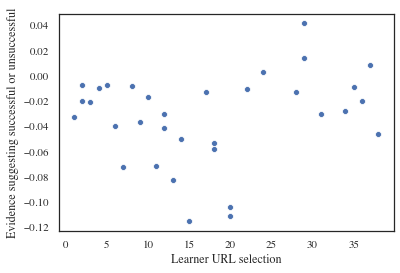

15 -0.9559606 -0.84082526
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14]


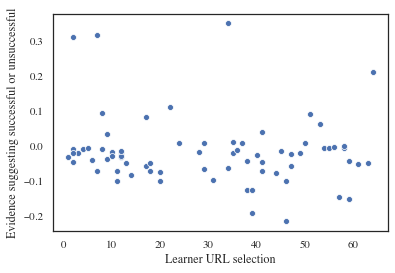

46 -0.71264577 -0.4970597
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 2, 7, 8, 9, 10, 11, 2, 12, 13, 14, 12, 17, 12, 17, 18, 12, 18, 20, 22, 24, 20, 28, 29, 34, 31, 29, 35, 34, 35, 36, 37, 38, 39, 38, 40, 39, 41, 44, 45, 41, 47, 49]


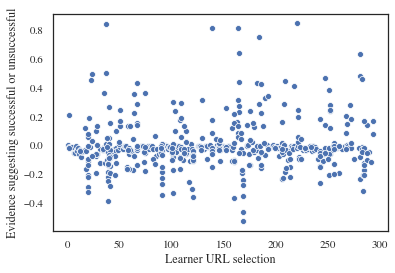

169
169 -1.5723608 -1.0460687
[0, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 17, 15, 17, 18, 12, 20, 18, 24, 22, 24, 20, 23, 28, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38, 39, 40, 41, 39, 44, 45, 47, 41, 47, 49, 51, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 64, 57, 63, 61, 63, 64, 60, 41, 67, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 103, 101, 103, 104, 105, 106, 107, 100, 109, 111, 114, 108, 114, 101, 91, 109, 100, 114, 116, 120, 112, 114, 117, 109, 112, 100, 101, 108, 67, 90, 39, 40, 91, 119, 120, 118, 120, 91, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 158, 152, 158, 159, 160, 139, 164, 160, 164, 165, 160, 167, 165, 168, 169, 168, 172, 164, 163, 164, 39, 20, 28, 20, 29, 28, 29, 31, 34, 35, 36, 37, 38, 39, 40, 20, 165, 167, 38, 169, 172, 173, 175, 169, 175, 177, 179, 174, 181, 179, 181, 178, 183, 182, 185, 184,

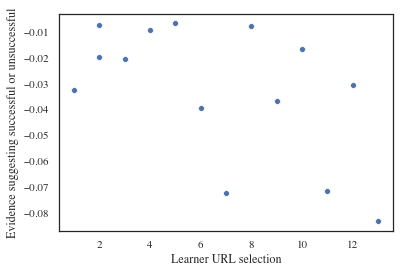

13 -0.3355657 -0.25260416
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12]


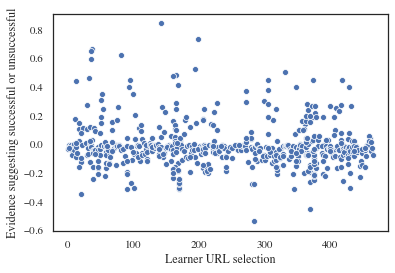

284
284 -1.6202536 -1.0858178
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 10, 2, 12, 13, 14, 17, 13, 17, 18, 12, 20, 18, 24, 22, 20, 28, 29, 31, 34, 29, 34, 35, 36, 37, 38, 37, 32, 35, 21, 20, 29, 31, 34, 35, 34, 39, 40, 168, 160, 164, 163, 39, 40, 41, 39, 44, 45, 47, 41, 47, 49, 46, 51, 54, 55, 56, 53, 51, 58, 50, 59, 58, 57, 51, 47, 50, 47, 51, 46, 58, 59, 57, 63, 64, 61, 63, 64, 60, 67, 41, 71, 72, 73, 67, 75, 67, 77, 78, 79, 81, 75, 74, 82, 85, 86, 90, 84, 88, 90, 91, 67, 99, 98, 97, 96, 95, 94, 91, 101, 103, 91, 103, 101, 103, 104, 105, 106, 107, 100, 109, 111, 114, 108, 114, 109, 112, 114, 116, 112, 120, 118, 120, 121, 91, 125, 126, 127, 129, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 160, 164, 163, 160, 139, 158, 139, 143, 145, 144, 143, 139, 147, 150, 149, 150, 151, 147, 146, 153, 154, 155, 156, 158, 152, 158, 159, 139, 160, 165, 167, 165, 168, 169, 172, 169, 168, 172, 160, 164, 160, 163, 164, 165, 160, 167, 165, 168, 169, 172, 169, 172, 169, 172, 173, 169, 175, 177, 17

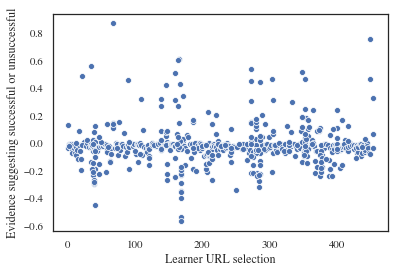

169
169 -3.184157 -2.6184833
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 15, 17, 1, 17, 12, 18, 20, 24, 22, 21, 20, 28, 29, 31, 29, 34, 35, 36, 35, 37, 36, 38, 37, 38, 39, 40, 41, 39, 44, 45, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 57, 63, 64, 61, 63, 64, 60, 67, 41, 67, 71, 72, 73, 67, 75, 74, 67, 74, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 104, 105, 106, 107, 100, 109, 111, 109, 108, 114, 116, 112, 120, 118, 120, 91, 121, 39, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 39, 139, 143, 144, 145, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 160, 139, 160, 164, 160, 165, 167, 168, 165, 39, 163, 164, 165, 167, 169, 172, 39, 40, 272, 275, 280, 169, 146, 139, 147, 272, 169, 172, 169, 139, 146, 147, 146, 39, 139, 147, 169, 172, 173, 169, 175, 177, 174, 179, 181, 178, 183, 182, 185, 186, 169, 188, 186, 190, 192, 189, 194, 186, 190, 194, 196, 197, 

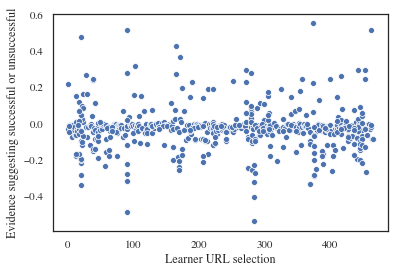

284
284 -1.7121099 -1.1757766
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 2, 11, 2, 12, 13, 14, 17, 15, 17, 12, 18, 20, 18, 22, 24, 22, 20, 28, 20, 21, 24, 28, 29, 31, 34, 29, 34, 35, 36, 37, 38, 21, 20, 24, 22, 38, 1, 20, 21, 24, 22, 18, 20, 18, 12, 17, 16, 38, 39, 40, 39, 41, 44, 45, 47, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 59, 58, 59, 57, 63, 64, 61, 63, 64, 60, 41, 67, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 91, 67, 91, 90, 91, 94, 95, 96, 97, 98, 99, 101, 91, 103, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 91, 103, 109, 114, 116, 112, 120, 118, 120, 91, 121, 125, 126, 127, 129, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 158, 152, 158, 159, 139, 160, 41, 46, 47, 160, 164, 160, 164, 165, 160, 167, 165, 168, 169, 172, 173, 175, 169, 172, 169, 175, 177, 174, 181, 179, 181, 178, 183, 182, 185, 186, 169, 188, 190, 186, 190, 192, 194, 189, 194, 196, 197, 198, 19

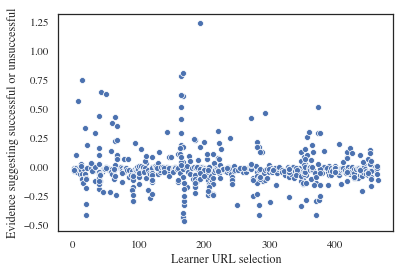

169
169 -4.2547703 -3.7892609
[0, 1, 2, 3, 4, 5, 6, 5, 7, 8, 9, 10, 11, 2, 12, 13, 14, 12, 14, 15, 17, 12, 18, 19, 18, 20, 24, 22, 20, 28, 29, 31, 34, 29, 34, 39, 40, 39, 40, 42, 41, 44, 45, 41, 47, 49, 46, 51, 53, 54, 51, 55, 56, 50, 58, 59, 58, 59, 57, 64, 63, 64, 60, 41, 67, 71, 72, 73, 67, 75, 74, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 67, 91, 101, 103, 120, 100, 91, 121, 120, 117, 112, 109, 114, 108, 91, 67, 90, 67, 94, 95, 96, 97, 98, 99, 103, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 39, 40, 91, 114, 116, 112, 120, 118, 120, 121, 91, 125, 126, 127, 129, 121, 39, 40, 39, 91, 120, 91, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 284, 148, 139, 147, 146, 143, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 160, 139, 41, 65, 63, 64, 63, 64, 165, 167, 168, 165, 39, 160, 164, 163, 41, 167, 163, 164, 165, 160, 167, 165, 167, 168, 165, 13, 168, 169, 172, 173, 169, 175, 177, 174, 179, 181, 178, 183, 182, 185, 169, 186, 188, 1

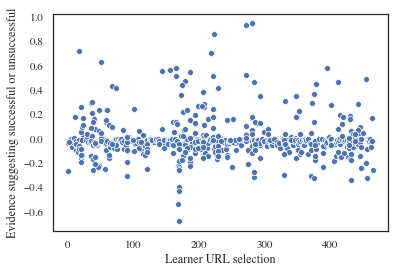

169
169 -2.1733086 -1.4959638
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 10, 2, 12, 13, 14, 15, 17, 18, 12, 18, 17, 18, 20, 24, 22, 20, 28, 29, 31, 29, 34, 35, 36, 35, 37, 36, 37, 38, 160, 162, 39, 40, 39, 40, 41, 39, 44, 45, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 58, 59, 39, 41, 47, 46, 51, 59, 47, 58, 47, 59, 57, 63, 64, 61, 63, 64, 60, 41, 67, 51, 59, 58, 50, 63, 64, 60, 67, 41, 71, 72, 73, 67, 73, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 91, 67, 94, 95, 96, 97, 98, 99, 101, 91, 103, 101, 103, 104, 105, 106, 107, 109, 100, 109, 111, 114, 108, 114, 91, 114, 116, 120, 112, 91, 117, 120, 118, 120, 91, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 91, 143, 144, 145, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 156, 158, 159, 139, 160, 164, 165, 160, 167, 168, 165, 168, 169, 172, 173, 175, 169, 172, 169, 175, 177, 174, 181, 179, 181, 178, 183, 182, 185, 186, 169, 188, 186, 190, 192, 194, 189, 194, 196, 197, 198, 193, 200, 201, 202,

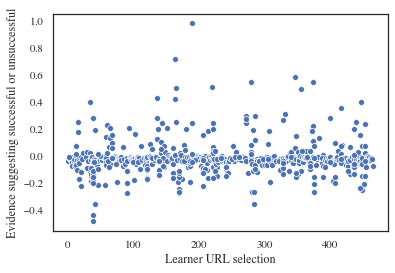

39
39 -4.0296755 -3.551441
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 13, 14, 12, 16, 17, 16, 15, 17, 12, 18, 20, 18, 24, 22, 20, 28, 29, 31, 34, 29, 34, 35, 36, 35, 36, 35, 36, 37, 38, 39, 38, 40, 41, 39, 44, 45, 47, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 63, 57, 64, 60, 64, 65, 63, 61, 60, 67, 39, 160, 39, 67, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91, 39, 40, 39, 91, 94, 95, 96, 97, 98, 99, 103, 101, 91, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 116, 112, 120, 118, 120, 121, 91]


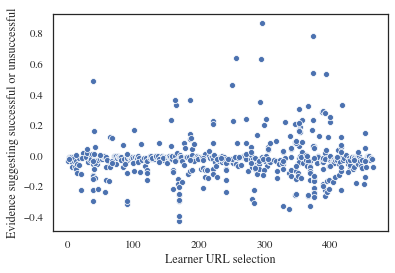

169
169 -2.3216243 -1.8959079
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 15, 17, 12, 18, 20, 24, 22, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38, 39, 38, 40, 39, 40, 41, 39, 44, 45, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 59, 58, 59, 57, 64, 63, 61, 63, 64, 60, 41, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 91, 67, 39, 91, 94, 95, 96, 97, 98, 99, 101, 91, 103, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 116, 112, 120, 118, 120, 91, 121, 39, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 157, 158, 159, 139, 160, 164, 160, 165, 167, 165, 168, 169, 168, 172, 169, 172, 173, 169, 175, 177, 174, 179, 181, 178, 183, 182, 185, 186, 169, 186, 169, 39, 40, 186, 188, 190, 186, 190, 192, 189, 194, 196, 197, 198, 193, 200, 201, 202, 203, 199, 205, 186, 206, 207, 208, 207, 208, 210, 206, 210, 212, 209, 214, 215, 216, 213, 218, 217, 220, 221, 20

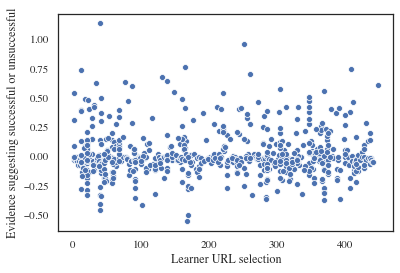

168
168 -1.8246717 -1.2717863
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 13, 14, 39, 40, 39, 41, 44, 45, 41, 47, 12, 17, 12, 13, 14, 17, 15, 17, 18, 12, 18, 20, 24, 22, 20, 21, 28, 20, 1, 38, 22, 21, 20, 22, 24, 21, 24, 1, 20, 21, 40, 28, 29, 31, 34, 29, 35, 34, 35, 36, 37, 38, 22, 21, 20, 165, 167, 41, 12, 165, 167, 160, 165, 164, 41, 49, 46, 53, 54, 55, 56, 50, 58, 59, 63, 57, 64, 60, 20, 21, 28, 20, 2, 12, 13, 14, 41, 12, 18, 12, 16, 57, 41, 58, 59, 57, 47, 41, 46, 51, 50, 59, 58, 59, 63, 57, 64, 61, 60, 67, 41, 12, 67, 71, 72, 73, 67, 77, 78, 79, 80, 74, 82, 81, 82, 85, 86, 84, 90, 84, 67, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 103, 104, 105, 106, 107, 100, 111, 108, 116, 112, 120, 118, 120, 121, 91, 125, 126, 127, 121, 131, 132, 133, 128, 135, 134, 137, 121, 139, 121, 157, 139, 158, 39, 67, 87, 90, 88, 90, 67, 91, 39, 41, 46, 47, 49, 46, 51, 87, 67, 90, 91, 67, 101, 91, 103, 109, 100, 108, 114, 112, 120, 91, 121, 129, 128, 134, 121, 139, 143, 39, 38, 41, 51, 50, 59, 58, 16

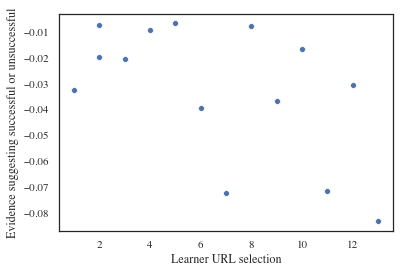

13 -0.3355657 -0.25260416
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12]


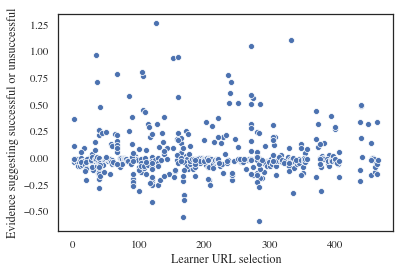

284
284 -1.5637628 -0.9741212
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 13, 14, 17, 15, 17, 18, 12, 18, 20, 24, 22, 20, 28, 29, 31, 29, 34, 35, 34, 36, 35, 36, 37, 38, 39, 38, 40, 35, 1, 12, 1, 18, 39, 40, 160, 164, 20, 28, 20, 28, 29, 31, 34, 29, 34, 35, 36, 37, 38, 37, 39, 38, 40, 39, 41, 39, 40, 39, 44, 45, 41, 47, 49, 51, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 64, 57, 63, 61, 60, 67, 41, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 86, 85, 90, 84, 67, 90, 88, 90, 91, 67, 94, 95, 96, 97, 98, 99, 91, 101, 103, 106, 107, 105, 104, 103, 109, 100, 111, 108, 114, 67, 90, 67, 91, 103, 91, 101, 100, 109, 108, 114, 120, 112, 118, 120, 91, 121, 125, 127, 129, 121, 129, 121, 129, 160, 164, 160, 165, 167, 168, 165, 169, 168, 172, 168, 172, 169, 172, 173, 175, 169, 175, 177, 179, 174, 181, 179, 181, 178, 183, 182, 185, 169, 186, 188, 186, 190, 192, 189, 194, 196, 197, 198, 193, 200, 201, 202, 203, 199, 186, 202, 199, 205, 186, 206, 207, 208, 207, 208, 210, 206, 212, 209, 215

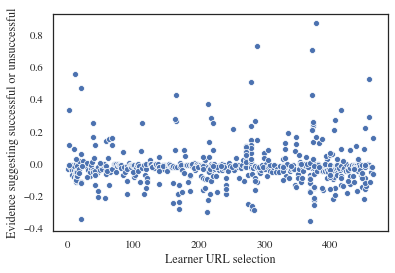

370
370 -0.9812896 -0.6255342
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 2, 11, 10, 9, 2, 12, 11, 12, 13, 14, 12, 16, 12, 17, 16, 15, 14, 17, 15, 17, 12, 18, 20, 24, 22, 20, 28, 29, 31, 34, 29, 35, 34, 35, 36, 37, 38, 21, 20, 21, 22, 39, 40, 41, 39, 44, 45, 41, 47, 41, 39, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 57, 63, 64, 63, 61, 64, 60, 41, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 116, 112, 120, 114, 117, 120, 118, 120, 121, 91, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 139, 140, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 160, 139, 160, 164, 165, 160, 167, 165, 168, 169, 168, 172, 163, 164, 169, 172, 173, 169, 175, 177, 174, 179, 181, 178, 183, 182, 185, 169, 186, 188, 186, 190, 192, 189, 194, 196, 197, 198, 193, 200, 201, 202, 203, 199, 205, 206, 186, 207, 

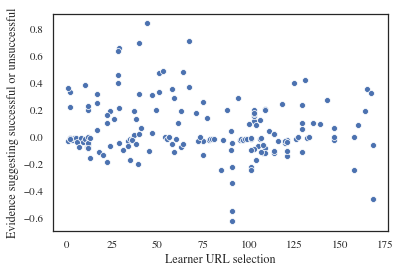

91
91 -2.943669 -2.3217163
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 2, 12, 1, 2, 10, 12, 2, 12, 29, 31, 34, 29, 34, 35, 36, 35, 37, 36, 37, 38, 39, 40, 12, 13, 12, 17, 12, 18, 20, 24, 28, 22, 29, 38, 13, 17, 24, 22, 28, 26, 28, 22, 17, 40, 41, 47, 58, 64, 59, 51, 63, 67, 75, 91, 90]


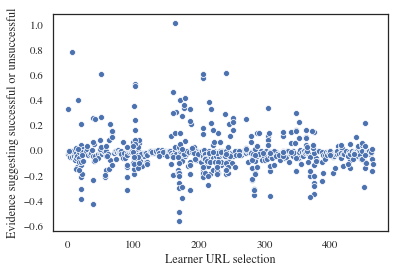

169
169 -3.129313 -2.5666375
[0, 20, 1, 2, 3, 4, 5, 6, 7, 8, 7, 9, 10, 11, 12, 2, 12, 1, 2, 12, 13, 14, 15, 17, 12, 18, 20, 24, 22, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38, 39, 40, 16, 12, 17, 16, 39, 40, 41, 39, 44, 45, 41, 47, 49, 51, 46, 51, 53, 54, 55, 56, 50, 59, 58, 51, 57, 51, 50, 58, 59, 63, 57, 64, 61, 64, 63, 60, 67, 41, 39, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91, 39, 91, 94, 95, 96, 97, 98, 99, 91, 103, 101, 103, 104, 105, 106, 107, 109, 100, 109, 111, 108, 114, 91, 114, 116, 120, 112, 118, 120, 91, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 157, 158, 159, 139, 160, 164, 160, 165, 167, 165, 168, 169, 168, 172, 101, 109, 108, 103, 100, 103, 91, 101, 160, 100, 108, 101, 100, 101, 108, 103, 164, 160, 164, 91, 101, 103, 100, 109, 103, 160, 164, 20, 21, 22, 24, 22, 21, 20, 18, 169, 172, 173, 169, 175, 174, 172, 175, 177, 179, 174, 1

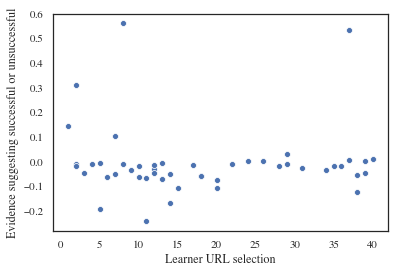

11 -1.3230777 -1.0826194
[0, 39, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 2, 8]


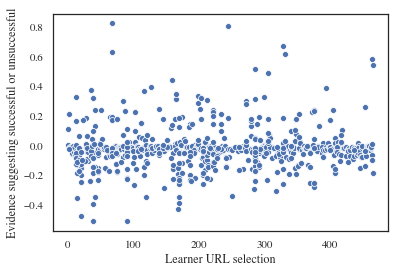

91
91 -2.2521927 -1.7455106
[0, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 15, 17, 12, 18, 12, 13, 14, 15, 17, 169, 172, 169, 168, 39, 168, 165, 20, 21, 28, 20, 28, 29, 31, 34, 29, 35, 36, 37, 38, 39, 40, 41, 39, 44, 45, 41, 47, 49, 51, 46, 50, 47, 46, 51, 53, 54, 55, 56, 50, 59, 58, 59, 64, 57, 63, 61, 63, 64, 60, 41, 67, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 88]


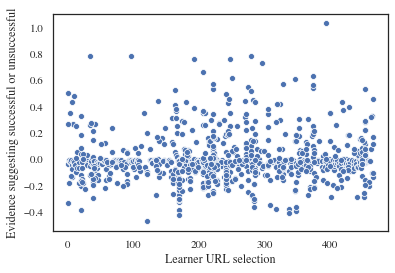

121
121 -2.5593114 -2.091339
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 8, 7, 6, 5, 3, 2, 11, 12, 13, 14, 13, 15, 17, 12, 18, 20, 18, 24, 22, 20, 28, 29, 31, 34, 29, 35, 34, 35, 36, 37, 38, 1, 38, 39, 40, 39, 41, 39, 40, 39, 41, 44, 45, 41, 47, 46, 51, 39, 40, 39, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 59, 58, 57, 51, 58, 59, 57, 63, 64, 61, 63, 64, 60, 41, 67, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 91, 96, 103, 109, 108, 116, 112, 120, 118, 121, 91, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 144, 145, 147, 139, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 139, 160, 159, 160, 139, 147, 158, 146, 158, 159, 139, 164, 160, 164, 163, 160, 165, 167, 165, 168, 169, 168, 172, 168, 169, 172, 168, 165, 164, 160, 167, 165, 160, 164, 160, 167, 169, 172, 169, 168, 20, 21, 24, 22, 26, 20, 22, 169, 172, 169, 168, 169, 172, 173, 169, 175, 177, 174, 179, 18

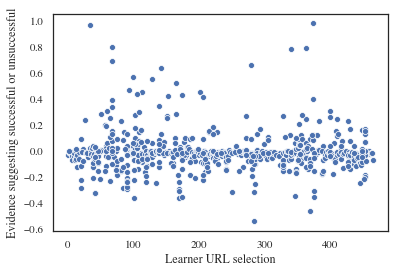

284
284 -1.6774418 -1.1367495
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 13, 14, 15, 17, 12, 18, 20, 24, 22, 20, 27, 20, 24, 20, 28, 29, 31, 34, 29, 34, 35, 36, 37, 38, 39, 38, 40, 39, 41, 44, 45, 41, 47, 46, 51, 50, 58, 59, 58, 59, 64, 57, 63, 61, 60, 67, 41, 71, 72, 73, 75, 67, 39, 40, 41, 39, 47, 41, 46, 51, 50, 58, 57, 63, 59, 64, 60, 41, 67, 75, 82, 67, 82, 75, 74, 82, 85, 67, 86, 84, 90, 91, 67, 91, 120, 118, 117, 114, 109, 112, 108, 101, 103, 100, 67, 90, 91, 94, 95, 96, 97, 98, 99, 91, 103, 101, 100, 109, 108, 114, 116, 120, 112, 121, 91, 100, 101, 103, 101, 103, 105, 106, 107, 109, 100, 108, 114, 120, 112, 118, 120, 91, 121, 125, 126, 127, 129, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 144, 145, 139, 147, 149, 150, 151, 146, 143, 152, 139, 153, 154, 155, 156, 152, 158, 159, 160, 139, 164, 160, 164, 46, 41, 47, 49, 51, 41, 65, 41, 67, 75, 67, 74, 82, 90, 84, 90, 91, 67, 91, 101, 103, 100, 109, 108, 114, 112, 120, 91, 121, 129, 121, 139, 128, 134, 139, 1

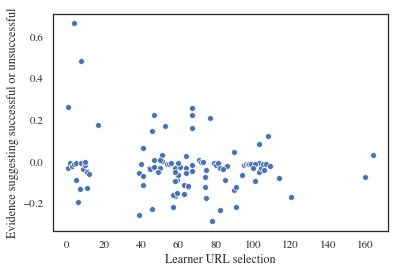

78 -0.48750544 -0.20269084
[0, 1, 2, 3, 4, 5, 4, 6, 5, 6, 7, 8, 9, 10, 8, 11, 10, 11, 17, 12, 1, 39, 40, 41, 39, 44, 45, 41, 47, 46, 51, 58, 59, 50, 59, 47, 58, 46, 58, 57, 63, 64, 63, 64, 60, 65, 64, 61, 60, 41, 67, 71, 72, 73, 75, 67, 75, 74, 75, 82, 74, 67, 47, 65, 49, 51, 53, 54, 55, 56, 59, 58, 50, 57, 67, 77]


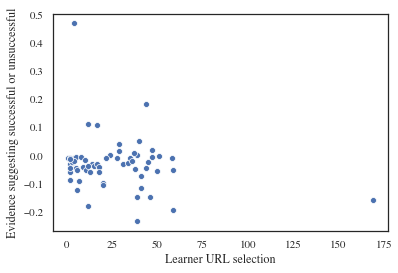

39 -0.54196453 -0.3087562
[0, 39, 2, 1, 2, 3, 4, 5, 4, 169, 2, 6, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 2, 11, 2, 12, 13, 14, 17, 15, 17, 18, 12, 18, 20, 24, 22, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38]


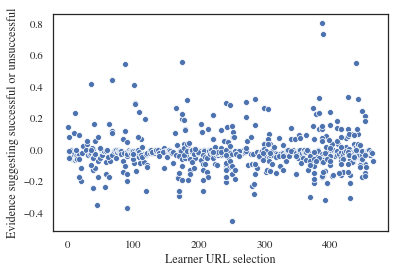

250
250 -1.6782199 -1.226593
[0, 39, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 11, 2, 10, 2, 12, 13, 14, 17, 15, 17, 12, 18, 20, 18, 24, 22, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38, 39, 38, 40, 39, 40, 41, 39, 45, 47, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 59, 58, 59, 57, 63, 64, 63, 64, 61, 60, 41, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 87, 90, 84, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 116, 112, 120, 117, 114, 109, 112, 103, 108, 100, 103, 91, 67, 87, 101, 91, 109, 114, 120, 118, 120, 91, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 160, 139, 164, 160, 165, 167, 165, 168, 169, 168, 172, 169, 172, 173, 175, 169, 175, 177, 179, 174, 181, 179, 181, 178, 182, 179, 175, 178, 175, 174, 178, 183, 182, 184, 182, 185, 169, 186, 188, 186, 190, 192, 189, 194, 196, 197, 198, 193, 200, 201, 2

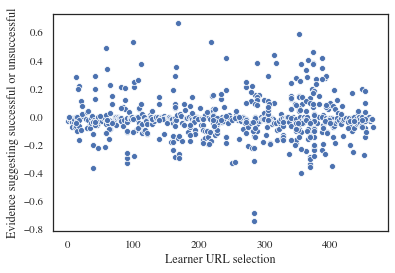

284
284 -2.1424267 -1.4012445
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 13, 14, 13, 17, 15, 16, 15, 17, 18, 12, 20, 18, 22, 24, 22, 20, 28, 29, 31, 32, 31, 29, 34, 35, 36, 37, 38, 39, 38, 40, 41, 39, 41, 42, 44, 45, 47, 41, 47, 49, 46, 51, 53, 54, 55, 56, 59, 58, 50, 58, 59, 57, 64, 63, 61, 63, 64, 60, 67, 41, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 87, 90, 82, 87, 82, 88, 90, 91, 67, 94, 95, 96, 97, 98, 99, 101, 91, 103, 100, 91, 101, 103, 104, 105, 106, 107, 109, 100, 109, 111, 114, 108, 114, 112, 109, 114, 116, 112, 120, 117, 101, 91, 100, 120, 108, 118, 120, 121, 91, 125, 126, 127, 129, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 139, 143, 144, 145, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 139, 160, 164, 163, 164, 160, 164, 163, 139, 160, 158, 39, 41, 60, 63, 64, 58, 60, 59, 160, 163, 164, 160, 164, 160, 165, 167, 165, 168, 169, 172, 173, 169, 175, 177, 174, 179, 181, 178, 183, 182, 185, 169, 186, 188, 186

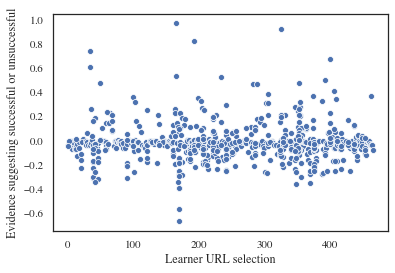

169
169 -3.5748732 -2.909681
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 13, 14, 15, 17, 12, 18, 20, 24, 22, 20, 28, 20, 29, 28, 29, 31, 29, 34, 35, 36, 37, 36, 38, 37, 38, 39, 38, 40, 41, 39, 44, 45, 47, 41, 49, 51, 46, 53, 54, 55, 56, 50, 58, 59, 58, 59, 64, 63, 57, 61, 60, 67, 41, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 90, 84, 67, 90, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 39, 160, 165, 167, 39, 100, 91, 101, 103, 165, 167, 39, 91, 100, 103, 104, 105, 106, 107, 100, 111, 109, 108, 114, 116, 112, 120, 118, 120, 91, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 121, 136, 121, 137, 121, 139, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 160, 139, 158, 139, 160, 39, 46, 41, 47, 41, 47, 39, 160, 164, 165, 160, 167, 34, 1, 160, 163, 164, 34, 169, 172, 163, 164, 168, 172, 173, 169, 175, 177, 174, 181, 179, 181, 178, 183, 169, 182, 172, 168, 169, 168, 172, 175, 169, 174, 179, 181, 178, 183, 182, 185, 169, 

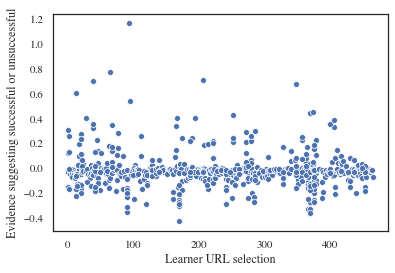

169
169 -2.3201318 -1.894502
[0, 1, 2, 3, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 13, 14, 15, 17, 18, 12, 20, 18, 24, 22, 12, 18, 17, 16, 17, 15, 18, 20, 22, 20, 22, 20, 21, 22, 24, 20, 28, 29, 31, 34, 29, 35, 34, 36, 35, 36, 37, 38, 1, 28, 39, 40, 41, 39, 44, 45, 44, 47, 41, 47, 46, 51, 50, 47, 49, 51, 46, 51, 53, 54, 55, 56, 58, 59, 50, 58, 59, 41, 59, 20, 64, 63, 57, 39, 60, 41, 63, 41, 20, 63, 64, 41, 63, 64, 61, 63, 64, 60, 41, 67, 71, 72, 73, 67, 75, 67, 75, 78, 79, 80, 81, 77, 75, 77, 74, 82, 85, 86, 84, 90, 88, 67, 91, 95, 96, 97, 98, 99, 94, 103, 101, 91, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 39, 112, 91, 114, 116, 112, 120, 117, 91, 67, 90, 67, 91, 120, 118, 120, 121, 91, 125, 126, 127, 129, 121, 129, 131, 132, 133, 128, 129, 134, 128, 135, 134, 137, 139, 121, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 139, 160, 164, 160, 164, 160, 165, 167, 165, 168, 169, 172, 169, 172, 169, 172, 173, 175, 169, 175, 177, 174, 181, 179, 181, 17

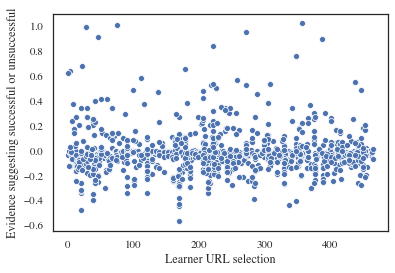

169
169 -2.9936228 -2.4285226
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 11, 10, 9, 8, 7, 6, 5, 4, 3, 12, 13, 14, 12, 14, 17, 15, 17, 18, 12, 18, 22, 39, 40, 39, 41, 44, 45, 41, 47, 49, 51, 46, 39, 40, 39, 46, 41, 47, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 57, 64, 63, 28, 29, 21, 20, 21, 24, 22, 20, 29, 31, 29, 34, 29, 46, 41, 47, 41, 50, 41, 51, 60, 41, 63, 64, 61, 63, 64, 41, 67, 71, 72, 73, 67, 75, 74, 67, 74, 75, 77, 75, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 84, 67, 87, 67, 90, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 104, 105, 106, 107, 109, 100, 109, 111, 108, 91, 112, 91, 116, 120, 112, 118, 120, 91, 121, 125, 126, 127, 121, 129, 121, 128, 129, 131, 132, 133, 128, 135, 134, 121, 39, 136, 121, 128, 121, 129, 121, 137, 139, 121, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 158, 152, 158, 159, 139, 160, 164, 160, 164, 160, 164, 160, 164, 160, 165, 167, 169, 172, 173, 169, 175, 177, 174, 179, 181, 178, 183, 182, 185, 186, 169, 188, 186, 190, 192, 

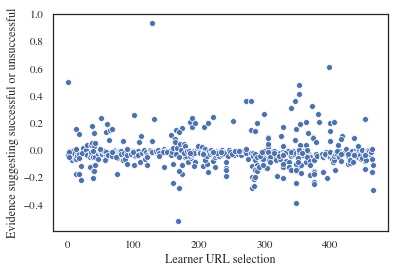

168
168 -1.6114634 -1.09112
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 2, 11, 2, 12, 13, 14, 17, 15, 17, 12, 18, 20, 18, 24, 22, 20, 28, 29, 31, 34, 29, 35, 34, 36, 35, 37, 36, 37, 38, 39, 40, 39, 40, 41, 39, 44, 45, 41, 47, 49, 51, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 63, 64, 57, 61, 60, 41, 67, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 101, 91, 103, 101, 103, 104, 105, 106, 107, 109, 100, 109, 111, 108, 114, 116, 112, 120, 118, 120, 91, 121, 125, 126, 127, 129, 121, 39, 40, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 158, 152, 158, 159, 160, 139, 164, 160, 164, 160, 165, 167]


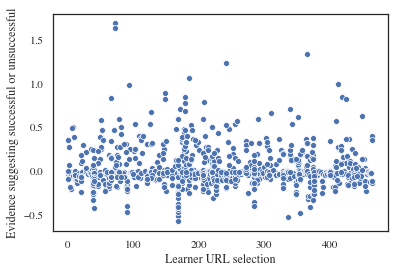

169
169 -2.9715505 -2.3982804
[0, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 8, 9, 10, 2, 12, 1, 11, 7, 10, 11, 12, 13, 14, 15, 17, 18, 12, 18, 20, 24, 22, 20, 28, 29, 31, 29, 34, 35, 36, 37, 36, 38, 37, 38, 39, 40, 39, 40, 39, 41, 44, 45, 41, 47, 49, 51, 46, 39, 40, 39, 41, 50, 51, 54, 55, 56, 53, 50, 59, 58, 41, 57, 64, 63, 51, 50, 58, 59, 57, 63, 64, 61, 63, 64, 60, 67, 41, 39, 67, 71, 72, 73, 75, 67, 75, 77, 78, 81, 75, 80, 79, 74, 82, 85, 86, 90, 84, 90, 88, 91, 67, 39, 40, 39, 91, 94, 95, 96, 97, 98, 99, 91, 103, 101, 103, 101, 91, 104, 105, 106, 107, 103, 109, 100, 109, 111, 109, 108, 114, 112, 94, 96, 91, 67, 103, 90, 91, 112, 114, 116, 120, 112, 120, 118, 91, 121, 39, 40, 39, 121, 125, 126, 127, 129, 121, 129, 131, 132, 133, 128, 134, 126, 121, 128, 135, 134, 136, 127, 129, 128, 137, 139, 121, 143, 129, 39, 139, 143, 144, 145, 147, 139, 147, 149, 147, 150, 151, 149, 146, 153, 154, 155, 156, 152, 158, 159, 139, 160, 39, 146, 149, 151, 146, 152, 147, 146, 147, 152, 146, 139, 39, 160, 39, 

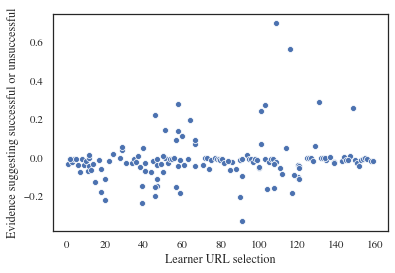

91
91 -1.261532 -0.9312183
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 13, 14, 15, 17, 12, 18, 20, 18, 24, 22, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38, 39, 40, 39, 41, 44, 45, 47, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 57, 51, 47, 50, 46, 47, 58, 46, 59, 64, 63, 57, 61, 60, 67, 41, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 90, 84, 88, 90]


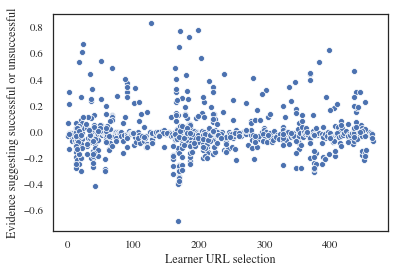

168
168 -2.974279 -2.290787
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 12, 17, 12, 18, 20, 24, 22, 20, 21, 22, 24, 21, 24, 22, 18, 20, 18, 12, 17, 16, 15, 14, 12, 2, 12, 13, 14, 17, 15, 17, 12, 18, 22, 20, 28, 29, 31, 34, 29, 35, 34, 35, 36, 37, 38, 39, 40, 39, 40, 39, 41, 44, 45, 41, 47, 49, 51, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 57, 63, 64, 61, 63, 64, 60, 67, 41, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 67, 75, 74, 90, 84, 67, 90, 87, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 101, 91, 103, 101, 103, 91, 103, 104, 105, 106, 107, 109, 100, 109, 91, 109, 111, 108, 114, 116, 109, 116, 112, 120, 118, 117, 120, 91, 121, 125, 126, 121, 129, 128, 127, 129, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 158, 152, 158, 159, 139, 160, 164, 160, 165, 167, 165, 168, 169, 172, 170, 172, 169, 168, 165, 164, 172, 173, 175, 169, 175, 177, 179, 174, 181, 179, 181, 178, 183, 182, 

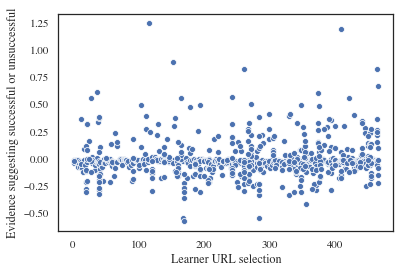

169
169 -3.0664868 -2.4972515
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 15, 17, 18, 12, 18, 20, 24, 22, 20, 28, 29, 31, 34, 29, 35, 34, 35, 36, 37, 38, 37, 20, 21, 22, 21, 24, 38, 39, 40, 41, 39, 40, 39, 40, 39, 41, 44, 45, 47, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 57, 64, 63, 61, 63, 64, 60, 41, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 90, 84, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 103, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 116, 91, 103, 109, 114, 112, 120, 118, 120, 121, 91, 125, 126, 127, 121, 129, 91, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 155, 156, 152, 158, 159, 139, 160, 164, 165, 160, 167, 168, 165, 39, 112, 116, 120, 121, 128, 134, 139, 121, 143, 147, 146, 158, 160, 165, 39, 139, 160, 164, 152, 139, 160, 158, 157, 154, 158, 139, 39, 40, 160, 164, 39, 40, 169, 172, 173, 169, 175, 177, 174, 179, 181, 178, 179, 182, 178, 183, 182, 185, 169, 186, 188,

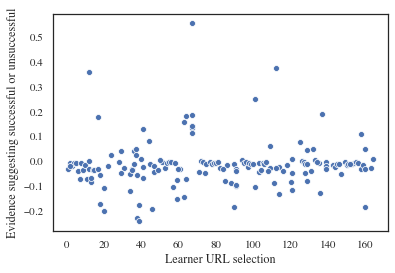

39 -4.3514495 -4.1098228
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 12, 13, 14, 17, 15, 17, 12, 18, 20, 18, 24, 22, 20, 28, 29, 31, 34, 29, 35, 34, 36, 35, 37, 36, 38, 37, 38, 39, 40, 41, 44, 45, 47, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 59, 58, 59, 64, 63, 57, 61, 63, 64, 60, 67, 41, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 67, 82, 85, 86, 90, 84, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 101, 91, 103, 101, 103, 104, 105, 106, 107, 109, 100, 109, 111, 108, 114, 112, 91, 114, 116, 120, 112, 118, 121, 91, 125, 126, 127, 129, 121, 132, 131, 133, 128, 135, 134, 129, 136, 129, 128, 137, 121, 139, 143, 160]


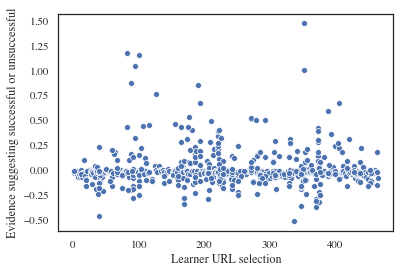

337
337 -1.786463 -1.2759185
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 2, 12, 13, 14, 17, 15, 17, 18, 12, 18, 20, 24, 22, 20, 28, 20, 29, 28, 29, 31, 34, 29, 34, 35, 36, 35, 37, 36, 38, 37, 39, 40, 39, 41, 44, 45, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 59, 58, 59, 64, 63, 57, 61, 60, 41, 67, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 90, 84, 86, 88, 90, 88, 67, 91, 39, 40, 39, 40, 91, 94, 95, 96, 97, 98, 99, 101, 91, 103, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 116, 91, 95, 103, 91, 101, 109, 116, 112, 120, 91, 121, 125, 126, 127, 121, 127, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 139, 143, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 156, 158, 159, 160, 139, 164, 160, 165, 167, 165, 100, 91, 101, 103, 107, 82, 67, 82, 84, 90, 39, 40, 169, 172, 169, 168, 172, 160, 164, 165, 160, 167, 169, 172, 173, 169, 175, 177, 181, 179, 174, 179, 181, 178, 183, 182, 185, 186, 169, 186, 190, 192, 189, 194, 196, 197, 198, 193, 200, 20

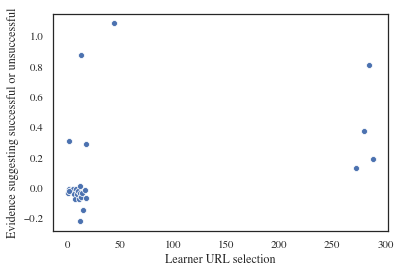

12 -0.7243558 -0.50761724
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 2]


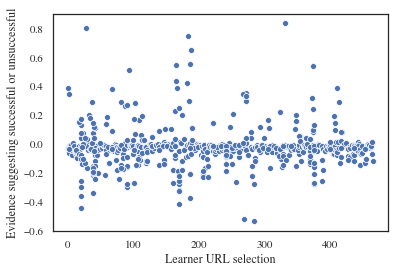

284
284 -1.6086333 -1.0751108
[0, 20, 1, 2, 1, 39, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 20, 24, 22, 20, 2, 17, 12, 13, 14, 15, 17, 18, 12, 18, 20, 24, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38, 39, 40, 39, 41, 44, 45, 47, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 57, 63, 64, 61, 60, 41, 67, 41, 71, 72, 73, 75, 67, 75, 74, 82, 84, 90, 67, 91, 103, 91, 101, 109, 100, 108, 112, 120, 114, 121, 91, 67, 90, 87, 84, 75, 82, 74, 41, 67, 41, 75, 77, 78, 79, 80, 81, 82, 85, 86, 90, 88, 90, 91, 94, 95, 96, 97, 98, 99, 101, 103, 104, 105, 106, 107, 100, 109, 91, 101, 103, 100, 109, 111, 114, 108, 114, 116, 120, 112, 118, 120, 91, 121, 125, 126, 127, 129, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 144, 145, 147, 139, 147, 148, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 158, 152, 158, 159, 160, 139, 160, 164, 163, 160, 164, 163, 164, 165, 167, 165, 168, 169, 172, 173, 175, 169, 175, 177, 174, 181, 179, 181, 178, 183, 182, 185, 184, 182, 169, 185, 186, 169

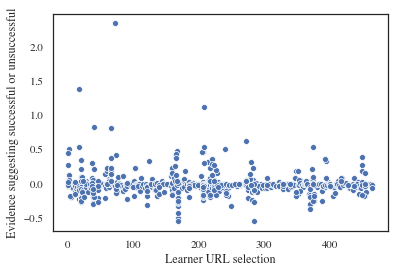

284
284 -2.5681221 -2.0172749
[0, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 8, 9, 10, 2, 12, 2, 11, 12, 13, 14, 15, 17, 12, 18, 17, 18, 20, 18, 24, 22, 20, 28, 29, 31, 34, 29, 35, 34, 35, 36, 37, 38, 1, 38, 37, 1, 38, 39, 38, 40, 21, 20, 28, 20, 1, 20, 24, 21, 22, 20, 39, 40, 39, 41, 44, 45, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 63, 57, 64, 61, 60, 63, 65, 61, 64, 63, 60, 67, 41, 71, 18, 20, 22, 24, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38, 40, 2, 12, 72, 73, 75, 67, 74, 67, 75, 67, 75, 77, 74, 67, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 103, 101, 91, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 116, 112, 120, 118, 120, 91, 121, 160, 125, 126, 127, 129, 121, 129, 131, 132, 133, 128, 134, 121, 134, 136, 135, 134, 137, 121, 139, 143, 139, 121, 143, 144, 145, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 158, 152, 158, 159, 160, 139, 164, 160, 164, 165, 167, 165, 168, 39, 168, 160, 39, 46, 41, 47, 39, 21, 20, 21, 24, 22, 26, 6

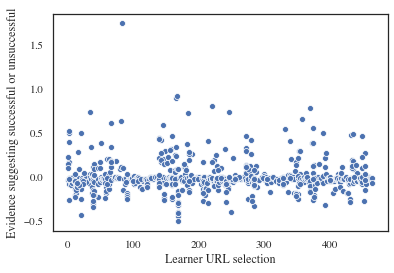

169
169 -1.3810574 -0.8809608
[0, 1, 2, 3, 4, 3, 2, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 15, 17, 18, 12, 18, 20, 24, 22, 20, 22, 20, 28, 29, 31, 34, 29, 34, 35, 36, 37, 36, 38, 37, 39, 38, 40, 39, 40, 2, 160, 39, 2, 1, 16, 12, 17, 1, 34, 2, 12, 13, 14, 39, 40, 41, 39, 41, 44, 45, 41, 47, 51, 46, 47, 50, 49, 46, 51, 41, 51, 53, 54, 55, 56, 58, 50, 59, 57, 41, 59, 58, 59, 63, 57, 64, 61, 63, 60, 65, 63, 64, 60, 41, 67, 71, 72, 73, 67, 75, 77, 78, 79, 81, 80, 74, 83, 67, 82, 67, 85, 86, 84, 90, 88, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 91, 114, 116, 120, 112, 118, 120, 91, 121, 39, 160, 39, 121, 91, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 139, 147, 143, 146, 147, 146, 139, 143, 147, 146, 152, 158, 157, 147, 149, 150, 151, 158, 143, 157, 139, 153, 154, 155, 156, 158, 159, 160, 139, 164, 160, 164, 163, 164, 139, 145, 139, 67, 90, 20, 21, 22, 24, 26, 20, 24, 165, 167, 39, 168, 16

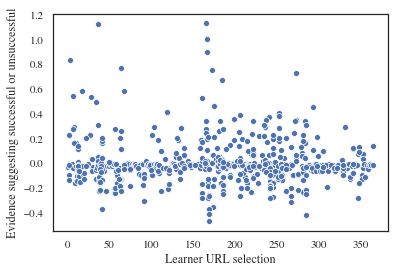

169
169 -2.0020394 -1.5353955
[0, 1, 2, 3, 4, 5, 6, 3, 8, 9, 11, 10, 12, 2, 7, 2, 12, 2, 7, 8, 10, 11, 2, 12, 13, 14, 12, 14, 15, 17, 12, 18, 17, 12, 18, 20, 24, 22, 20, 27, 22, 28, 29, 31, 34, 29, 35, 34, 36, 35, 37, 36, 38, 37, 39, 38, 40, 41, 39, 44, 45, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 59, 58, 59, 57, 64, 63, 165, 167, 165, 167, 41, 63, 64, 167, 39, 57, 41, 59, 58, 64, 57, 63, 36, 37, 38, 39, 38, 40, 41, 39, 64, 63, 41, 61, 63, 64, 60, 41, 67, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 67, 82, 85, 86, 90, 84, 88, 90, 91, 67, 94, 95, 96, 97, 98, 99, 101, 91, 103, 101, 103, 104, 105, 106, 107, 100, 109, 108, 103, 109, 111, 108, 114, 116, 112, 120, 119, 91, 120, 118, 91, 121, 125, 126, 127, 129, 121, 129, 132, 133, 128, 129, 134, 131, 128, 134, 135, 134, 137, 139, 121, 143, 144, 145, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 158, 152, 158, 159, 160, 139, 159, 139, 160, 164, 160, 165, 167, 160, 164, 160, 165, 167, 165, 168, 169, 168, 172, 168, 34, 167, 168, 165, 12,

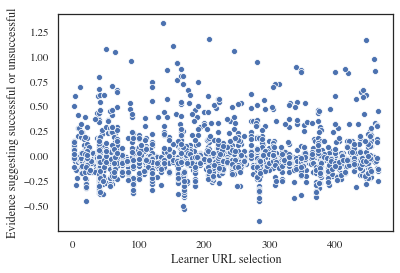

284
284 -2.4060602 -1.7573473
[0, 20, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 2, 7, 5, 9, 2, 10, 11, 2, 3, 4, 5, 12, 2, 12, 1, 2, 12, 13, 14, 15, 17, 16, 17, 14, 17, 12, 18, 12, 17, 12, 20, 18, 24, 22, 18, 20, 28, 29, 31, 32, 31, 29, 34, 35, 36, 35, 37, 36, 37, 38, 20, 1, 21, 20, 21, 22, 24, 22, 12, 14, 1, 21, 20, 38, 39, 38, 40, 39, 40, 38, 39, 20, 21, 24, 21, 22, 39, 40, 39, 41, 44, 45, 44, 45, 44, 47, 41, 47, 49, 46, 51, 53, 54, 39, 40, 39, 38, 37, 38, 50, 41, 51, 50, 47, 46, 41, 40, 38, 39, 38, 39, 41, 47, 41, 46, 41, 40, 39, 47, 46, 51, 54, 51, 55, 56, 54, 59, 50, 58, 57, 51, 41, 58, 59, 63, 57, 64, 39, 40, 39, 60, 41, 64, 63, 41, 67, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 39, 67, 82, 85, 39, 40, 87, 67, 90, 91, 67, 94, 95, 96, 97, 98, 99, 101, 91, 103, 101, 103, 104, 105, 106, 107, 109, 100, 109, 111, 108, 114, 116, 112, 120, 91, 121, 39, 67, 84, 86, 90, 84, 39, 57, 41, 58, 59, 39, 91, 112, 114, 39, 160, 164, 39, 60, 41, 64, 63, 67, 121, 139, 90, 120, 158, 157, 100, 91, 1

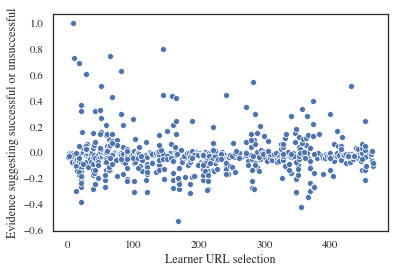

168
168 -1.6490202 -1.1159761
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 10, 8, 2, 12, 13, 14, 15, 17, 12, 18, 20, 22, 24, 20, 24, 22, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38, 28, 20, 39, 40, 39, 41, 47, 46, 51, 50, 57, 63, 64, 58, 59, 60, 39, 40, 41, 39, 44, 45, 47, 41, 47, 49, 51, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 57, 63, 64, 61, 63, 41, 51, 50, 58, 64, 63, 57, 64, 60, 41, 67, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 84, 85, 86, 82, 67, 82, 84, 90, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 91, 114, 116, 120, 112, 118, 120, 91, 121, 125, 126, 127, 121, 129, 131, 132, 133, 128, 135, 134, 137, 121, 139, 143, 144, 145, 139, 147, 149, 150, 146, 153, 154, 155, 156, 158, 152, 159, 139, 160, 20, 28, 146, 139, 147, 151, 146, 158, 152, 139, 160, 18, 20, 24, 22, 20, 18, 12, 18, 17, 21, 20, 28, 29, 28, 160, 164, 160, 165, 167, 160, 164, 160, 165, 167]


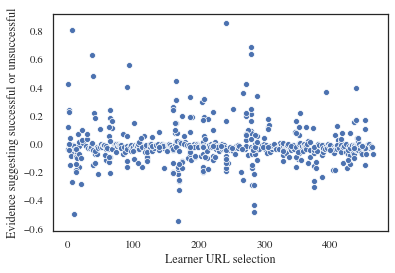

168
168 -1.7311167 -1.1854113
[0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 6, 5, 4, 3, 2, 9, 10, 11, 2, 12, 13, 14, 15, 17, 16, 17, 12, 18, 20, 18, 22, 24, 22, 20, 28, 29, 31, 29, 34, 35, 36, 37, 38, 37, 39, 40, 39, 41, 44, 45, 41, 47, 49, 46, 51, 53, 54, 55, 56, 58, 50, 59, 58, 59, 63, 64, 57, 61, 63, 64, 60, 41, 67, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91, 1, 2, 1, 12, 2, 12, 13, 91, 94, 95, 96, 97, 98, 99, 101, 91, 103, 101, 103, 104, 105, 106, 107, 100, 109, 39, 41, 65, 63, 65, 64, 63, 91, 109, 111, 108, 114, 109, 114, 108, 116, 112, 120, 118, 120, 121, 91, 121, 125, 126, 127, 129, 121, 129, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 144, 145, 139, 147, 139, 147, 149, 150, 151, 146, 153, 154, 155, 156, 152, 158, 159, 139, 160, 164, 160, 165, 167]


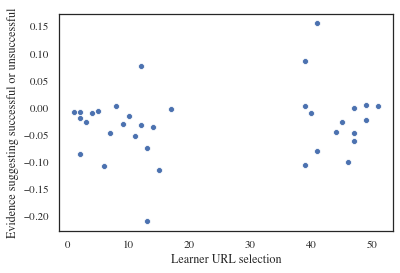

13 -1.9399253 -1.730202
[0, 39, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 39, 40, 12, 13, 41, 39, 44, 45, 47, 41, 47]


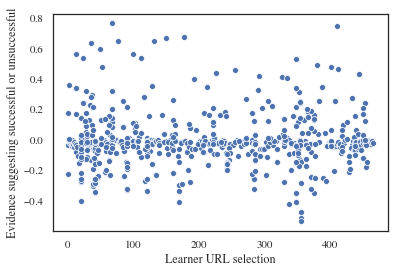

355
355 -3.192387 -2.658484
[0, 1, 2, 3, 4, 5, 6, 2, 7, 8, 9, 10, 11, 2, 12, 13, 14, 15, 12, 18, 20, 24, 20, 28, 29, 31, 29, 34, 35, 36, 35, 37, 36, 37, 38, 20, 38, 37, 36, 1, 21, 28, 13, 28, 29, 34, 32, 29, 28, 20, 21, 36, 37, 38, 20, 27, 24, 13, 24, 20, 21, 20, 28, 29, 1, 20, 39, 40, 39, 41, 39, 44, 45, 41, 49, 46, 53, 54, 55, 56, 50, 58, 59, 58, 59, 57, 63, 64, 61, 63, 64, 60, 41, 67, 71, 72, 73, 67, 77, 78, 79, 80, 81, 74, 82, 85, 67, 41, 20, 41, 67, 84, 86, 84, 90, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 103, 100, 112, 91, 108, 120, 121, 128, 123, 121, 125, 126, 127, 121, 131, 132, 133, 128, 135, 134, 137, 121, 139, 144, 145, 139, 149, 150, 151, 146, 91, 120, 117, 103, 100, 91, 67, 90, 67, 91, 103, 104, 105, 106, 107, 100, 111, 108, 116, 112, 120, 118, 120, 91, 121, 128, 134, 121, 139, 146, 153, 154, 155, 156, 158, 152, 158, 159, 139, 160, 164, 160, 39, 40, 39, 41, 160, 164, 41, 46, 41, 47, 46, 51, 50, 59, 58, 63, 64, 63, 60, 57, 41, 64, 67, 41, 67, 84, 90, 91, 67, 160, 164, 1

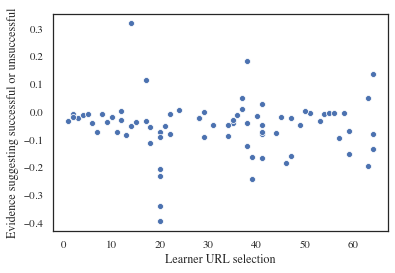

20
20 -2.0351384 -1.6423329
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 17, 15, 17, 12, 18, 14, 18, 20, 24, 22, 20, 22, 20, 28, 29, 31, 34, 29, 35, 34, 35, 36, 37, 38, 20, 21]


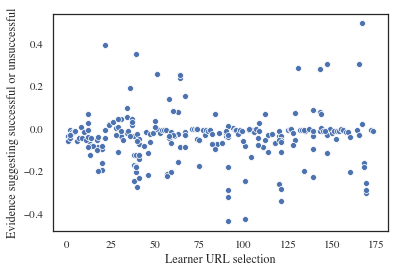

91
91 -1.9530046 -1.5183227
[0, 1, 2, 39, 40, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, 13, 14, 12, 17, 12, 18, 20, 24, 22, 20, 28, 29, 31, 32, 31, 34, 29, 34, 35, 36, 37, 38, 39, 38, 40, 39, 41, 44, 45, 41, 47, 49, 46, 51, 53, 54, 55, 56, 50, 58, 59, 58, 59, 57, 64, 63, 61, 63, 64, 60, 41, 67, 71, 72, 73, 75, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91, 94, 95, 96, 97, 98, 99, 91, 101, 103, 104, 105, 106, 107, 100, 109, 111, 108, 114, 116, 112, 120, 118, 120, 91, 121, 125, 126, 127, 129, 121, 131, 132, 133, 128, 135, 134, 137, 139, 121, 143, 144, 145, 139, 147, 12, 13, 14, 15, 17, 18, 12, 20, 18, 24, 22, 26, 22, 20, 28, 29, 31, 29, 34, 35, 36, 37, 36, 38, 37, 38, 39, 40, 39, 41, 47, 51, 46, 50, 59, 58, 64, 63, 57, 60, 41, 67, 75, 74, 82, 84, 90, 91, 67, 101, 91, 103, 101]


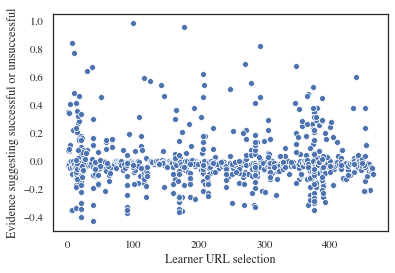

39
39 -4.377651 -3.945403
[0, 20, 1, 2, 3, 4, 3, 5, 6, 7, 8, 9, 10, 11, 10, 9, 8, 4, 5, 7, 6, 2, 12, 13, 14, 12, 14, 17, 15, 17, 18, 12, 18, 20, 24, 22, 20, 28, 20, 29, 28, 29, 31, 29, 34, 35, 36, 37, 38, 37, 1, 16, 12, 17, 16, 17, 15, 1, 20, 21, 24, 22, 17, 12, 18, 20, 22, 21, 22, 24, 16, 12, 17, 12, 18, 20, 24, 17, 16, 14, 39, 40, 39, 41, 44, 45, 41, 47, 41, 47, 49, 46, 51, 41, 51, 53, 54, 55, 56, 50, 58, 59, 57, 47, 41, 46, 58, 51, 59, 50, 47, 58, 59, 57, 63, 64, 61, 63, 64, 60, 67, 41, 71, 72, 73, 67, 75, 77, 78, 79, 80, 81, 74, 82, 85, 86, 84, 90, 88, 90, 67, 91]


In [15]:
for i in range(75):
    score_s, score_u = score_traj(trajectories.iloc[i])
    score_s = np.array(score_s)
    score_u = np.array(score_u)
    score_delta = (score_s - score_u)[:-1]
    sb.scatterplot(trajectories.iloc[i][1:-1], score_delta)
    plt.xlabel('Learner URL selection')
    plt.ylabel('Evidence suggesting successful or unsuccessful')
    #plt.title('title')
    plt.show()
    
    traj_pos = np.argmin(score_delta)
    url = trajectories.iloc[i][traj_pos + 1]
    if score_delta[traj_pos] < -0.3:
        print(url)
    print(url, score_s[traj_pos], score_u[traj_pos])
    print(trajectories.iloc[i][:traj_pos + 1])
    

In [ ]:
# url_of_interest = 68
# for i in range(100):
#     if url_of_interest in trajectories.iloc[i]:
#         score_s, score_u = score_traj(trajectories.iloc[i])
#         score_s = np.array(score_s)
#         score_u = np.array(score_u)
#         score_delta = (score_s - score_u)[:-1]
        
#         url_scores = []
#         for j, url in enumerate(trajectories.iloc[i]):
#             if url == url_of_interest:
#                 url_scores.append(score_delta[j-1])
# plt.hist(url_scores)

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)
plt.plot(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Strategy, Products, Capability Work, and Teams ROC plot')
plt.legend(loc="lower right")
plt.show()

# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
# roc_auc[i] = auc(fpr[i], tpr[i])
# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# # user list key - session level
# AM_userList = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-userList-key-sessionLevel.csv')
# AM_userList

# # learning pathway network edge lists - edge list for each student in the course that represent a directed 
# # transitions networks  of students pathway through the courses content modules.  this is all students.
# AM_edgelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-edges-cohort.csv')
# AM_edgelist[:5]

In [ ]:
incoming_traj[0].shape

In [ ]:
model.predict([0,1,3,4,5,6])[0,-1].tolist()

In [ ]:
x = np.array([0,1,2,3,4,5,6]).reshape(1,-1)
s = np.zeros(x.shape)
model2.predict([x,s])[0,-1].tolist()

In [ ]:
np.argsort([7,5,1,2])

In [ ]:
# appendix to the node list that provides a set of XY coordinates to generate a common layout for all networks 
# produced in the analysis.  force atlas with parameterization <- what is this?
AM_node_coord = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-coordinates-FA2.csv')
AM_node_coord[:5]

In [ ]:
# student identifiers and performance statistics, certification, and enrollment data
AM_id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
AM_id_and_performance['certGrp'].unique()

In [ ]:
# meta data includes the course title, run dates
LaaL_meta = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-meta.csv')
LaaL_meta

In [ ]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data

# LaaL_edgelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules.csv')
# LaaL_edgelist

LaaL_modules = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules00.csv')
len(LaaL_modules)
LaaL_modules[460:470]

In [ ]:
LaaL_edelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-edges.csv')
LaaL_edelist[:5]

In [ ]:
LaaL_nodelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes.csv')
LaaL_nodelist[:5]

In [ ]:
AM_nodelist = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-cohort.csv')
AM_nodelist

In [ ]:
LaaL_node_coord = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes-coordinates-FA2.csv')
LaaL_node_coord[:5]

In [ ]:
LaaL_id_and_performance = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
LaaL_id_and_performance[:5]

count = LaaL_id_and_performance[LaaL_id_and_performance['certGrp']== 'Certified (< 65% Grade)']
len(count)